**<h2>Computing Water Potential Energy Surface Using Behler and Parinello Symmetry Functions** 

Importing relevant packages from PyTorch

In [2]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

import math


Loading the data (energies and geometries) for 1000 water molecule configurations in .xyz form

In [3]:
energies_water = np.genfromtxt('./water/energies.txt')
print("Energies file has",np.shape(energies_water),"entries")
#geometry_data =  read('./water/structures.xyz',index=':')
#print("Geometry file has",np.shape(geometry_data),"entries")
#print(geometry_data[0])
#geometry_data = np.array(geometry_data)

Energies file has (1000,) entries


In [4]:
# see https://education.molssi.org/python-data-analysis/01-numpy-arrays/index.html
#https://stackoverflow.com/questions/23353585/got-1-columns-instead-of-error-in-numpy

file_location = os.path.join('water', 'structures.xyz')
xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode',invalid_raise = False)
# where invalid_raise = False was used to skip all lines in the xyz file that only have one column
symbols = xyz_file[:,0]
coordinates_water = (xyz_file[:,1:-1])
coordinates_water = coordinates_water.astype(np.float)
atomic_numbers_water = (xyz_file[:,-1])


<ipython-input-4-0a86150c1726>:5: ConversionWarning: Some errors were detected !
    Line #6 (got 1 columns instead of 5)
    Line #11 (got 1 columns instead of 5)
    Line #16 (got 1 columns instead of 5)
    Line #21 (got 1 columns instead of 5)
    Line #26 (got 1 columns instead of 5)
    Line #31 (got 1 columns instead of 5)
    Line #36 (got 1 columns instead of 5)
    Line #41 (got 1 columns instead of 5)
    Line #46 (got 1 columns instead of 5)
    Line #51 (got 1 columns instead of 5)
    Line #56 (got 1 columns instead of 5)
    Line #61 (got 1 columns instead of 5)
    Line #66 (got 1 columns instead of 5)
    Line #71 (got 1 columns instead of 5)
    Line #76 (got 1 columns instead of 5)
    Line #81 (got 1 columns instead of 5)
    Line #86 (got 1 columns instead of 5)
    Line #91 (got 1 columns instead of 5)
    Line #96 (got 1 columns instead of 5)
    Line #101 (got 1 columns instead of 5)
    Line #106 (got 1 columns instead of 5)
    Line #111 (got 1 columns instead

In [5]:
atomic_numbers_water = atomic_numbers_water.astype(int)
atomic_numbers_water = np.reshape(atomic_numbers_water,(len(coordinates_water),1))
#atomic_numbers_water = torch.from_numpy(atomic_numbers_water)
print(type(atomic_numbers_water))
print(atomic_numbers_water)
print(np.shape(atomic_numbers_water))

<class 'numpy.ndarray'>
[[1]
 [1]
 [8]
 ...
 [1]
 [1]
 [8]]
(3000, 1)


In [6]:
## Alternatively loading the data in .npy form
# # The data was downloaded from http://www.quantum-machine.org/datasets/ (Densities dataset--> water.zip)
# # The data includes energies, densities and structure for water molecules
# #For each dataset, structures are given in with positions in Bohr and the energies are given in kcal/mol 
# energy_data = np.load('./water_102/dft_energies.npy')
# print("Energies file has",np.shape(energy_data),"entries")
# geometry_data =  np.load('./water-2/water_102/structures.npy')
# print("Geometry file has",np.shape(geometry_data),"entries")
# print(type(energy_data))
# print(type(geometry_data))

In [7]:
print(coordinates_water)
print(np.shape(coordinates_water))

[[ 0.          0.769767    0.55746937]
 [ 0.         -0.71017975  0.50340914]
 [ 0.         -0.0037242  -0.06630491]
 ...
 [ 0.          0.81441381  0.59863567]
 [ 0.         -0.76145415  0.54978922]
 [ 0.         -0.00330998 -0.07177656]]
(3000, 3)


**<h2>Cutoff Function** 
    $$f_c(R_{ij}) = 
    \begin{cases}
        0.5 \times \big[\cos\big(\frac{\pi R_{ij}}{R_c}\big)+1\big]  & \text{for } R_{ij} \leq R_c\\
        0  & \text{for } R_{ij} > R_c
    \end{cases}
    $$
    
In the Behler and Parinello paper the Cutoff radius $R_c$ was taken to be $6$  Ångströms, or 11.3384 Bohr radii. (Remember, 1 Ångström is $10^{-10}$m)

In [8]:
def fc(R,Rc):
    if R <= Rc:
        fcutoff = 0.5 * (np.cos(np.pi*R/Rc)+1)
    else:
        fcutoff = 0
    return fcutoff

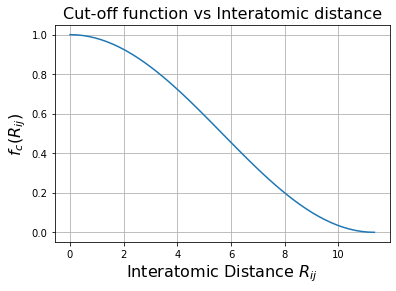

In [9]:
# Plotting fc as a function of interatomic distance Rij

Rc  = 11.3384 # Bohr

Rij     = np.linspace(0,Rc)
fcutoff = np.zeros(np.size(Rij))

for i in range(np.size(Rij)):
    fcutoff[i] = fc(Rij[i],Rc)

plt.plot(Rij,fcutoff)
plt.title('Cut-off function vs Interatomic distance', fontsize=16)
plt.xlabel('Interatomic Distance $R_{ij}$', fontsize=16)
plt.ylabel('$f_c(R_{ij})$', fontsize=16)
plt.grid()

**<h2>Pairwise Distances**

$$Dp = \begin{bmatrix} R_{00} & R_{01} & R_{02} \\ R_{10} & R_{11} & R_{12} \\ R_{20} & R_{21} & R_{22} \end{bmatrix} = \begin{bmatrix} 0 & R_{01} & R_{02} \\ R_{01} & 0 & R_{12} \\ R_{02} & R_{12} & 0 \end{bmatrix} $$

In [10]:
i = 0                                     # i-th molecule
N = 3                                     # N atoms per molecule
coord = coordinates_water[N*i:N*(i+1),:]  # Let's take the coordinates of the ith water molecule in our dataset and compute
                                          # pairwise distances between all of its 3 atom
    
def pairwise_distances(coord):                       # we pass in the coordinates of the 3 atoms in the water molecule
    N = len(coord)
    pairwise_dist_matrix = np.zeros((N,N))       # Initialise the matrix
    for i in range(0,N-1):
        for j in range(i+1,N):
            pairwise_dist_matrix[i][j] =  np.sqrt(sum( (coord[i,:] - coord[j,:])**2 ))
            pairwise_dist_matrix[j][i] = pairwise_dist_matrix[i][j]
    return pairwise_dist_matrix

Dp = pairwise_distances(coord)
print(Dp)



[[0.         1.48093379 0.99367147]
 [1.48093379 0.         0.9075536 ]
 [0.99367147 0.9075536  0.        ]]


**<h2>From Cartesian to Generalised Coordinates**

**<h3>Radial Symmetry Functions**
    
<h3>$$G_i^1 = \sum_{j \neq i}^{\text{all}} e^{-\eta (R_{ij}-R_s)^2} f_c (R_{ij})$$

In [11]:
heta = 0.1
Rs   = 0
N    = 3

def radial_BP_symm_func(Dp,N,heta,Rs):
    G_mu1 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)
    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(0,i):
            G_mu1[i] = G_mu1[i] + np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
        for j in range(i+1,N):
            G_mu1[i] = G_mu1[i] +  np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
    return G_mu1

Gmu1 = radial_BP_symm_func(Dp,N,heta,Rs)
print(Gmu1)

[1.65865495 1.67618952 1.79537284]


**<h3> Angular Symmetry Functions**

$$G_i^2 = 2^{1-\zeta} \sum_{j,k \neq i}^{\text{all}} (1+\lambda \cos \theta_{ijk})^\zeta \times e^{-\eta (R_{ij}^2+R_{ik}^2+R_{jk}^2 )} f_c (R_{ij})f_c (R_{ik})f_c (R_{jk})$$
    
with parameters $\lambda = +1, -1$, $\eta$ and $\zeta$

In [12]:
lambdaa = 1     
zeta    = 0.2
heta    = 0.1

N = len(coord)

def angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta):
    G_mu2 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)

    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(N):           
            for k in range(N):
                if j != i and k !=i:
                    R_vec_ij = coord[i,:] - coord[j,:]
                    R_vec_jk = coord[i,:] - coord[k,:]
                    cos_theta_ijk  = np.dot(R_vec_ij, R_vec_jk)/(Dp[i][j]*Dp[i][k])
                    G_mu2[i]   = G_mu2[i] + (  1 + lambdaa * cos_theta_ijk )**zeta  \
                                * np.exp( -heta * (Dp[i][j]**2 + Dp[i][k]**2 + Dp[j][k]**2) ) \
                                * fc(Dp[i][j],Rc) * fc(Dp[i][k],Rc) * fc(Dp[j][k],Rc)            
        G_mu2[i]   = 2**(1-zeta) * G_mu2[i] 
    return G_mu2

Gmu2 = angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta)
print(Gmu2)

[5.19473151 5.24520024 5.28298916]


In [13]:
np.cos(180)

-0.5984600690578581

**<h2>Rotation functions**

**<h3>Rotation Matrix**

In [14]:
def random_rotation_matrix():
    theta = np.arccos(2*np.random.uniform(low = 0,high = 1)-1)
    phi = np.random.uniform(low = 0,high = 2*np.pi)
    u = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    theta = np.random.uniform(low = 0,high = 2*np.pi)
    A = np.zeros((3,3))
    A[0][0] = np.cos(theta) + (u[0]**2)*(1-np.cos(theta))
    A[0][1] = u[0]*u[1]*(1-np.cos(theta)) - u[2]*np.sin(theta)
    A[0][2] = u[0]*u[2]*(1-np.cos(theta)) + u[1]*np.sin(theta)
    A[1][0] = u[1]*u[0]*(1-np.cos(theta)) + u[2]*np.sin(theta)
    A[1][1] = np.cos(theta) + (u[1]**2)*(1-np.cos(theta))
    A[1][2] = u[1]*u[2]*(1-np.cos(theta)) - u[0]*np.sin(theta)
    A[2][0] = u[2]*u[0]*(1-np.cos(theta)) - u[1]*np.sin(theta)
    A[2][1] = u[2]*u[1]*(1-np.cos(theta)) + u[0]*np.sin(theta)
    A[2][2] = np.cos(theta) + (u[2]**2)*(1-np.cos(theta))
    return A


Function to randomly rotate molecules in the data set

In [15]:
def rotate_data(A,data):
    data = np.array(data)
    m = np.shape(data)[1]
    for i in range(m):
        data[:,i] = np.matmul(A,data[:,i])
    return data

NameError: name 'data_size' is not defined

In [17]:
def rotate_data_set(coordinates,N,number_of_features,data_size,training_set_size, \
                    use_atom_num_as_feat,atomic_numbers,heta,Rs,lambdaa,zeta):

    #Randomly rotate each molecule in the data
    rotated_molec_coord = np.zeros((np.shape(coordinates)))
    for i in range(data_size):
        coord = coordinates_water[N*i:N*(i+1),:]
        coord = coord - coord[2,:]                   # move origin to oxygen for each molecule before rotating
        coord = np.transpose(coord)
        A = random_rotation_matrix()
        rotated_molec_coord[N*i:N*(i+1),:] = np.transpose(rotate_data(A,coord))
        
    
    G_rot = np.zeros((len(rotated_molec_coord), number_of_features))
    print(np.shape(G_rot))
    data_size = int(len(rotated_molec_coord)/N)
    for i in range(data_size):
        coord = rotated_molec_coord[N*i:N*(i+1),:]
        Dp    = pairwise_distances(coord)
        for j in range(0,number_of_features,2):
            if j < number_of_features - 1: 
                G_rot[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j]) 
                G_rot[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
            else:
                G_rot[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j]) 
                if number_of_features%2 == 0:
                    G_rot[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
    
    # Computing variance and mean on the training data only!
    G_rot_train = G_rot[:training_set_size,:]
    var  = np.var(G_rot_train,axis=0)
    mean = np.mean(G_rot_train,axis=0)

    G_rot_norm = np.zeros((len(coordinates), number_of_features))
    # normalize all data (training and test), using training set mean and variance
    for i in range(np.shape(G_rot)[0]):
        for j in range(np.shape(G_rot)[1]):
            G_rot_norm[i,j] = (G_rot[i,j]-mean[j])/var[j]   
    
    
    if use_atom_num_as_feat == 1:
        G_rot_norm = np.append(G_rot_norm, atomic_numbers, axis=1)           # Adding atomic number as a feature
    


    data_set_rot = np.vsplit(G_rot_norm,data_size)     # Going from a (3000,2) np.array to a (1000,3,2) list
    #data_set = np.random.permutation(training_set)
    data_set_rot = torch.FloatTensor(data_set_rot)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

    
    
    # Splitting the dataset into training and test set
    training_set_rot         = data_set_rot[:training_set_size]
    test_set_rot             = data_set_rot[training_set_size:]
    
    return test_set_rot


**<h2>Training and Test Set**

In [18]:
# N_H2O                    = 3       # number of atoms per molecule
# number_of_features_H2O   = 3       # number of features (symmetry functions) for each atom (we create one radial)
#                                    # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.
# use_atom_num_as_feat     = int(0)       # Use atomic number of each element as an extra feature for training?
# data_size_H2O            = np.shape(energies_water)[0]

In [19]:
def create_dataset(N,number_of_features,coordinates,energies,atomic_numbers, use_atom_num_as_feat,batches):
    

    # Randomly picking the parameters from within a range
    heta   = np.linspace(0.01, 4, num=number_of_features)
    random.shuffle(heta)

    Rs     = np.linspace(0, 1, num=number_of_features)
    random.shuffle(Rs)

    lambdaa = np.ones(number_of_features)
    random.shuffle(lambdaa)

    zeta    = np.linspace(0, 8, num=number_of_features)
    random.shuffle(zeta)

    # A good set of parameters if we have 6 features    
    if number_of_features == 6:
        heta    = [0.01,  4.,    3.202, 1.606, 2.404, 0.808] 
        zeta    = [8.,  1.6, 3.2, 4.8, 6.4, 0. ]
        Rs      = [0.8, 0.4, 0.2, 1.,  0.,  0.6]
        lambdaa = [1., 1., 1., 1., 1., 1.]
        
        
    #Used to compare convergence for different numbers of features (we set them all to have the same values for a fair comparison)        
    heta    = np.ones(20)
    zeta    = np.ones(20)
    Rs      = np.zeros(20)
    lambdaa = np.ones(20)
        
        


    data_size            = np.shape(energies)[0]        # We have 1000 water molecule conformations
    test_set_size        = 100
    training_set_size    = data_size - test_set_size


    G = np.zeros((len(coordinates), number_of_features))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)

    for i in range(data_size):
        coord = coordinates[N*i:N*(i+1),:]
        Dp    = pairwise_distances(coord)
        for j in range(0,number_of_features,2):
            if j < number_of_features - 1:      # for j = number_of_features compute either 1 or 2 symmetry functions depending on whether number_of_features is odd or even
                G[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j])
                G[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
            else:                  
                G[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j])
                if number_of_features % 2 == 0:    #i.e. if number of features is even
                    G[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])

    
    # Computing variance and mean on the training data only!
    G_train = G[:training_set_size,:]
    var  = np.var(G_train,axis=0)
    mean = np.mean(G_train,axis=0)
    print(mean)
    G_norm = np.zeros((len(coordinates), number_of_features))
    print(np.shape(G))
    # normalize all data (training and test), using training set mean and variance
    for i in range(np.shape(G)[0]):
        for j in range(np.shape(G)[1]):
            G_norm[i,j] = (G[i,j]-mean[j])/var[j]   
        
    print(type(G_norm))  
    
    if use_atom_num_as_feat == 1:
        G_norm = np.append(G_norm, atomic_numbers, axis=1)    # Adding atomic number as a feature
       
        
    data_set = np.vsplit(G_norm,data_size)                    # Going from a (3000,6) np.array to a (1000,3,6) list
    #data_set = np.random.permutation(training_set)
    data_set = torch.FloatTensor(data_set)                    # Going from a (1000,3,2) list to a a (1000,3,2) tensor
   
    # print(data_set[0])
    # print(data_set[0][1][1])

    labels = energies          # turning energies into a (1000) tensor

    
# #     print(np.shape(labels))
# #     print(np.shape(data_set))
#     shuffler = np.random.permutation(len(labels))

#     data_set = data_set[shuffler]

#     labels = labels[shuffler]

# #     print(np.shape(labels))
# #     print(np.shape(data_set))
    
    

    # Computing variance and mean on the training data only!
    lab_train = labels[:training_set_size]
    var_lab  = np.var(lab_train,axis=0)
    mean_lab = np.mean(lab_train,axis=0)

    labels_norm = np.zeros((np.shape(labels)))
    # normalize all data (training and test), using training set mean and variance
    for i in range(np.shape(labels)[0]):
        labels_norm[i] = (labels[i]-mean_lab)/var_lab  
    
    
    labels_norm = torch.FloatTensor(labels_norm)      
    
    
    # Splitting the dataset into training and test set
    training_set         = data_set[:training_set_size]
    test_set             = data_set[training_set_size:]
    test_set_rot         = rotate_data_set(coordinates,N,number_of_features,data_size,training_set_size, \
                                          use_atom_num_as_feat,atomic_numbers,heta,Rs,lambdaa,zeta)

    train_labels         = labels_norm[:training_set_size]
    train_labels         = torch.FloatTensor(train_labels)
    test_labels          = labels_norm[training_set_size:]
    test_labels          = torch.FloatTensor(test_labels)

    # Dataset
    dataset = TensorDataset(training_set, train_labels)
    #print(dataset[0])

    # Creating the batches
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batches, #25, #300,
                                           shuffle=True, num_workers=2, drop_last=False) # ?????

    print(np.shape(training_set))
    
    return [training_set, test_set, train_labels, test_labels, dataloader,var_lab,mean_lab, test_set_rot,labels_norm]

In [20]:
# data_water = create_dataset(N_H2O, number_of_features_H2O ,coordinates_water,energies_water, \
#                       atomic_numbers_water,use_atom_num_as_feat, 300)



In [21]:
# training_set = data_water[0]
# print('Training set:')
# print(type(training_set))
# print(np.shape(training_set))
# test_set     = data_water[1]
# print('\n')
# print('Test set:')
# print(type(test_set))
# print(np.shape(test_set))
# train_labels = data_water[2]
# print('\n')
# print('Training labels:')
# print(type(train_labels))
# print(np.shape(train_labels))
# test_labels  = data_water[3]
# print('\n')
# print('Test labels:')
# print(type(test_labels))
# print(np.shape(test_labels))
# dataloader   = data_water[4]
# print('\n')
# print('data_waterloader:')
# print(type(dataloader))
# print(np.shape(dataloader))

# var_lab = data_water[5]
# print('\n')
# print('Variance of labels:')
# print(type(var_lab))
# print(var_lab)

# mean_lab = data_water[6]
# print('\n')
# print('Mean value of labels:')
# print(type(mean_lab))
# print(mean_lab)

# test_set_rot = data_water[7]
# print('\n')
# print('Rotated test set:')
# print(type(test_set_rot))
# print(np.shape(test_set_rot))

# labels_norm = data_water[8]
# print('\n')
# print('Normalised labels:')
# print(type(labels_norm))
# print(np.shape(labels_norm))

**<h2>Building Neural Network Architecture**

In [22]:
class Subnets_H2O(nn.Module):
    def __init__(self,number_of_features):
        super(Subnets_H2O, self).__init__()
        num_hid_feat = math.ceil(number_of_features/2)
        self.fc1 = nn.Linear(number_of_features, num_hid_feat)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(num_hid_feat, num_hid_feat)
        self.fc3 = nn.Linear(num_hid_feat, 1)


    def forward(self, x,train = True):
        x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN_H2O(nn.Module):
    def __init__(self,number_of_features):
        super(BPNN_H2O, self).__init__()
        self.network1 = Subnets_H2O(number_of_features)
        self.network2 = Subnets_H2O(number_of_features)
        self.network3 = Subnets_H2O(number_of_features)
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2, x3,train = True):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        x3 = self.network3(x3)
        
        
        x = torch.cat((x1, x2, x3), 0) 
#        x = self.fc_out(x)
        x = torch.sum(x)                   #??????????????????????????? try average pooling?
        x = torch.reshape(x,[1])
        return x

    
# model = BPNN_H2O(3) #+1)                # +1 because he have added the atomic number as a feature
# x1, x2, x3 = training_set[0]
# print('x1',x1)
# print('x2',x2)
# print('x3',x3)


# output = model(x1, x2, x3,number_of_features_H2O)# +1)
# print('output')
# print(output*var_lab+mean_lab)


# print(model)

# print('Network1')

# print('layer 1')
# print('weights')
# print(model.network1.fc1.weight)
# print('biases')
# print(model.network1.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network1.fc2.weight)
# print('biases')
# print(model.network1.fc2.bias)

# print('layer 3')
# print('weights')
# print(model.network1.fc3.weight)
# print('biases')
# print(model.network1.fc3.bias)

# print('Network2')

# print('layer 1')
# print('weights')
# print(model.network2.fc1.weight)
# print('biases')
# print(model.network2.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network2.fc2.weight)
# print('biases')
# print(model.network2.fc2.bias)

# print('layer 3')
# print('weights')
# print(model.network2.fc3.weight)
# print('biases')
# print(model.network2.fc3.bias)

# print('Network3')

# print('layer 1')
# print('weights')
# print(model.network3.fc1.weight)
# print('biases')
# print(model.network3.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network3.fc2.weight)
# print('biases')
# print(model.network3.fc2.bias)


# print('layer 3')
# print('weights')
# print(model.network3.fc3.weight)
# print('biases')
# print(model.network3.fc3.bias)

In [23]:
# x1, x2, x3 = training_set[0]
# print('x1',x1)
# print('x2',x2)
# print('x3',x3)


# output = model(x1, x2, x3,number_of_features_H2O+1)
# print('output')
# print(output*var_lab+mean_lab)

In [24]:
## Manually compute neural Network output

# w11 = model.network1.fc1.weight
# b11 = model.network1.fc1.bias
# print(np.shape(w11))
# x1 = np.reshape(x1,(2,1))
# x1 = np.array(x1)
# print(np.shape(x1))

# w11 = w11.cpu().detach().numpy()
# b11 = b11.cpu().detach().numpy()
# #b11 = np.transpose(b11)
# b11 = np.reshape(b11,(3,1))
# print(np.shape(b11))
# print(type(x1))
# print(type(w11))

# a11 = np.matmul(w11,x1) + b11
# a11 = np.tanh(a11)
# print(a11)
# #print(torch.tensordot(w11,x1))


**<h2>Training the Neural Network**

In [25]:
def training(learning_rate, nepochs,net,dataloader):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), learning_rate) 
    #torch.optim.LBFGS(net.parameters(), lr=0.001, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, line_search_fn=None)
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)

    train_loss = np.zeros(nepochs)
    test_loss = np.zeros(nepochs)

    train_acc = np.zeros(nepochs)
    test_acc = np.zeros(nepochs)

    #===========================================================================
    for epoch in range(nepochs):          # loop over the dataset multiple times
    #===========================================================================
    
        running_loss = 0.0                #  Initialise losses at the start of each epoch 
        epoch_train_loss = 0.0             
        epoch_test_loss = 0.0
    
    
        counter = 0                               # ranges from 0 to the number of elements in each batch 
                                                  # eg if we have 900 train. ex. and 25 batches, there will
                                                  # be 36 elements in each batch.
        #---------------------------------------
        for i, data in enumerate(dataloader, 0):  # scan the whole dataset in each epoch, batch by batch (i ranges over batches)
        #---------------------------------------
            inputs, labels = data                 # get the inputs; data is a list of [inputs, labels]

            # zero the parameter gradients
            optimizer.zero_grad()                 # Calling .backward() mutiple times accumulates the gradient (by addition) 
                                                  # for each parameter. This is why you should call optimizer.zero_grad() 
                                                  # after each .step() call. 

            # forward + backward + optimize
        
        
            outputs = torch.zeros(np.shape(inputs)[0])
            for j in range(np.shape(inputs)[0]):
                outputs[j] = net(inputs[j][0],inputs[j][1],inputs[j][2])  # The net is designed to take a (3 x num_features)
                # tensor as an input, so when we are doing batch gd, we do a loop over all elements of the batch to create an
                # output vector with as many elements as the batch size. If our net was designed to take one row as input we 
                # wouldn't have needed the for loop, we could have had a vectorised implementation, i.e. outputs = net(inputs)
            
            
            
            loss = criterion(outputs, labels) # a single value, same as loss.item(), which is the mean loss for each mini-batch
            loss.backward()                   # performs one back-propagation step 
            optimizer.step()                  # update the network parameters (perform an update step)

            # print statistics
            running_loss += loss.item()        # loss.item() contains loss of entire mini-batch, divided by the batch size, i.e. mean
                                               # we accumulate this loss over as many mini-batches as we like until we set it to zero after printing it
            epoch_train_loss += loss.item()    # cumulative loss for each epoch (sum of mean loss for all mini-batches)
                                               # so we ve divided here by the number of train. ex. in one mini-batch (mean)
                                               # thus all we need to do at the end of the epoch is divide by the number of mini-batches
        
            net_test_set = torch.zeros(np.shape(test_set)[0]) # outputs(predictions) of network if we input the test set
            with torch.no_grad():                             # The wrapper with torch.no_grad() temporarily sets all of 
                                                              # the requires_grad flags to false, i.e. makes all the 
                                                              # operations in the block have no gradients
                for k in range(np.shape(test_set)[0]):
                       net_test_set[k] = net(test_set[k][0],test_set[k][1],test_set[k][2])
                epoch_test_loss += criterion(net_test_set, test_labels).item() # sum test mean batch losses throughout epoch           
            if i % 10 == 2:    # print average loss every 10 mini-batches
                print('[%d, %5d] loss: %.5f' %
                      (epoch + 1, i + 1, running_loss/10))
                running_loss = 0.0
            counter += 1
            #------------------------------------       
        # Now we have added up the loss (both for training and test set) over all mini batches     
        train_loss[epoch] = epoch_train_loss/counter   # divide by number or training examples in one batch 
                                                       # to obtain average training loss for each epoch
        test_loss[epoch] = epoch_test_loss/counter
        epoch_train_loss = 0.0
        epoch_test_loss = 0.0

    #=================================================================================
    
    print('Finished Training')
    
    return train_loss, test_loss

In [26]:
# Training for 3 Behler and Parinello features, batch size = 300 

N_H2O                    = 3       # number of atoms per molecule
number_of_features_H2O   = 6 #3       # number of features (radial and angular symmetry functions) to be used
use_atom_num_as_feat     = int(0)       # Use atomic number of each element as an extra feature for training?
data_size_H2O            = np.shape(energies_water)[0]
batch_size               = 25 #300 
test_set_size = 100


data_water = create_dataset(N_H2O, number_of_features_H2O ,coordinates_water,energies_water, \
                      atomic_numbers_water,use_atom_num_as_feat, batch_size)

training_set = data_water[0];     test_set     = data_water[1];
train_labels = data_water[2];     test_labels  = data_water[3];
dataloader   = data_water[4];     var_lab = data_water[5]; 
mean_lab = data_water[6];         test_set_rot = data_water[7];
labels_norm = data_water[8];


[0.57507889 0.45271239 0.57507889 0.45271239 0.57507889 0.45271239]
(3000, 6)
<class 'numpy.ndarray'>
(3000, 6)
torch.Size([900, 3, 6])


In [27]:
# Create and initialise the model
net = BPNN_H2O(number_of_features_H2O)   #+1) # +1 if you are adding atomic number as a feature

In [28]:
# Train for nepochs using learning_rate = 0.0001
nepochs = 20 #1500
learning_rate = 0.0001 #0.005


losses = training(learning_rate , nepochs, net, dataloader)
train_loss_G_3_feat = losses[0]
test_loss_G_3_feat  = losses[1]

[1,     3] loss: 0.08185
[1,    13] loss: 0.25329
[1,    23] loss: 0.25480
[1,    33] loss: 0.22142
[2,     3] loss: 0.07305
[2,    13] loss: 0.21628
[2,    23] loss: 0.20118
[2,    33] loss: 0.19860
[3,     3] loss: 0.05907
[3,    13] loss: 0.18465


KeyboardInterrupt: 

In [35]:
# Plotting loss functions
def plot_train_test_loss(train_loss, test_loss, nepochs, num_feat_G):
    x = np.arange(1,nepochs+1)

    plt.plot(x,train_loss,'blue',label = 'Training loss')
    plt.plot(x,test_loss,'red',label = 'Test loss')

    #plt.ylim([0,0.075])

    plt.ticklabel_format(useOffset=False, style='plain')
    plt.xlabel('Epoch',fontsize=14)
    plt.ylabel('Loss function',fontsize=14)
    plt.title('Average loss function per epoch for $H_2O$ training and test set',fontsize=14)
    plt.grid()
    plt.legend()
    plt.savefig('loss_graph_H2O_G_{0}'.format(num_feat_G),bbox_inches='tight')
    plt.show()
    
    return

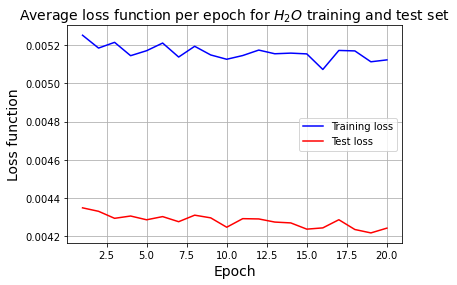

In [36]:
plot_train_test_loss(train_loss_G_3_feat,test_loss_G_3_feat,nepochs,number_of_features_H2O)

In [37]:
prediction = np.zeros(test_set_size)
for i in range(test_set_size):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)#[0]

    
print(prediction)

[-0.46727288 -0.45966285 -0.08840507 -0.25618482 -0.36480796  0.04455274
  0.15641296  0.06448114  0.13132173  0.11771655 -0.50033689 -0.3126415
 -0.08109719 -0.45301342 -0.39152193 -0.09833252 -0.11328721  0.08724988
 -0.17165327 -0.61469907  0.40145975  0.1720075  -0.07618159  0.08093882
 -0.48187989  0.09771156 -0.5329845   0.08378696 -0.22846842  0.09708881
  0.2875042   0.20740533  0.52269053 -0.31283808 -0.02923548 -0.29756975
 -0.32358575 -0.16255563  0.23877105 -0.42299706 -0.15753675 -0.48038602
  0.54949307 -0.09815669 -0.26158005  0.34449604 -0.32665896  0.06545138
  0.01785213  0.11552042  0.05106241 -0.14311135 -0.14755046 -0.1575439
 -0.02029514  0.12049377 -0.41778868  0.24319392 -0.1644783  -0.54436499
  0.06445098 -0.19770992  0.20177218 -0.56904763  0.0371924   0.13542807
 -0.18139982  0.30230325  0.70709324 -0.31025326 -0.11287522 -0.00447863
  0.27288353  0.56428981  0.44275641  0.16900864 -0.02722347 -0.14426637
 -0.49623823 -0.39662731  0.04576743 -0.20238292  0.0

In [38]:
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))

torch.Size([900])
-2.6490954e-09


In [39]:
print(mean_lab)

-13813.419735561924


In [40]:
def plot_prediction(prediction,test_labels,var_lab,mean_lab, number_of_features_H2O):
    prediction = torch.tensor(prediction)

    x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
    print(min(torch.cat((test_labels,prediction),0)))
    y = x
    plt.plot(test_labels*var_lab+mean_lab,prediction*var_lab+mean_lab, 'o', color='blue', label = 'Test set')
    plt.plot(x,y, color='red',label = 'y=x')
    plt.grid()
    #plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
    #plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
    #plt.ylim([-13822,-13800])
    #plt.ticklabel_format(axis="y", style="plain")
    plt.ticklabel_format(useOffset=False, style='plain')
    #plt.tick_params(axis='both',labelsize=14)
    plt.xlabel('Actual $H_2O$ energy value (kcal/mol)',fontsize=14)
    plt.ylabel('Predicted energy value (kcal/mol)',fontsize=14)
    plt.title('Actual vs Predicted energy value for $H_2O$ molecules',fontsize=15)
    plt.legend()
    plt.savefig('predicted_energies_H2O_G_{0}'.format(number_of_features_H2O),bbox_inches='tight')
    plt.show()

    return


tensor(-0.6147, dtype=torch.float64)


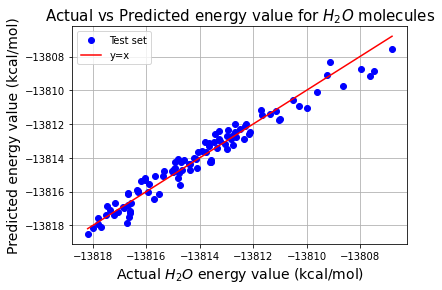

In [41]:
plot_prediction(prediction,test_labels,var_lab,mean_lab,number_of_features_H2O)

In [42]:
print(net.network1.fc1.weight)

Parameter containing:
tensor([[ 0.0225, -0.0837,  0.4186, -0.1038, -0.2901, -0.0561],
        [ 0.6530, -0.0961,  0.6532, -0.0044,  0.3303, -0.3511],
        [ 0.2893, -0.1791, -0.1163, -0.1706,  0.0865, -0.0165]],
       requires_grad=True)


In [ ]:
# Training for 6 Behler and Parinello features, batch size = 300 

number_of_features_H2O   = 6       # number of features (radial and angular symmetry functions) to be used
batch_size               = 300 

data_water = create_dataset(N_H2O, number_of_features_H2O ,coordinates_water,energies_water, \
                      atomic_numbers_water,use_atom_num_as_feat, batch_size)

training_set = data_water[0];     test_set     = data_water[1];
train_labels = data_water[2];     test_labels  = data_water[3];
dataloader   = data_water[4];     var_lab = data_water[5]; 
mean_lab = data_water[6];         test_set_rot = data_water[7];
labels_norm = data_water[8];

# Create and initialise the model
net = BPNN_H2O(number_of_features_H2O)   #+1) # +1 if you are adding atomic number as a feature

# # Train for  nepochs using learning_rate = 0.0001
# nepochs = 2000
# learning_rate=0.0001

losses = training(learning_rate , nepochs, net, dataloader)
train_loss_G_6_feat = losses[0]
test_loss_G_6_feat  = losses[1]


plot_train_test_loss(train_loss_G_6_feat,test_loss_G_6_feat,nepochs,number_of_features_H2O)


prediction = np.zeros(test_set_size)
for i in range(test_set_size):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)#[0]    
print(prediction)
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))
print(mean_lab)

plot_prediction(prediction,test_labels,var_lab,mean_lab,number_of_features_H2O)


In [ ]:
# Training for 9 Behler and Parinello features, batch size = 300 

number_of_features_H2O   = 9       # number of features (radial and angular symmetry functions) to be used
batch_size               = 300 

data_water = create_dataset(N_H2O, number_of_features_H2O ,coordinates_water,energies_water, \
                      atomic_numbers_water,use_atom_num_as_feat, batch_size)

training_set = data_water[0];     test_set     = data_water[1];
train_labels = data_water[2];     test_labels  = data_water[3];
dataloader   = data_water[4];     var_lab = data_water[5]; 
mean_lab = data_water[6];         test_set_rot = data_water[7];
labels_norm = data_water[8];

# Create and initialise the model
net = BPNN_H2O(number_of_features_H2O)   #+1) # +1 if you are adding atomic number as a feature

# Train for  nepochs using learning_rate = 0.0001
# nepochs = 20000
# learning_rate=0.0001

losses = training(learning_rate , nepochs, net9, dataloader)
train_loss_G_9_feat = losses[0]
test_loss_G_9_feat  = losses[1]


plot_train_test_loss(train_loss_G_9_feat,test_loss_G_9_feat,nepochs,number_of_features_H2O)
prediction = np.zeros(test_set_size)


for i in range(test_set_size):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)#[0]    
print(prediction)
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))
print(mean_lab)


plot_prediction(prediction,test_labels,var_lab,mean_lab,number_of_features_H2O)

In [ ]:
# Training for 12 Behler and Parinello features, batch size = 300 

number_of_features_H2O   = 12       # number of features (radial and angular symmetry functions) to be used
batch_size               = 300 

data_water = create_dataset(N_H2O, number_of_features_H2O ,coordinates_water,energies_water, \
                      atomic_numbers_water,use_atom_num_as_feat, batch_size)

training_set = data_water[0];     test_set     = data_water[1];
train_labels = data_water[2];     test_labels  = data_water[3];
dataloader   = data_water[4];     var_lab = data_water[5]; 
mean_lab = data_water[6];         test_set_rot = data_water[7];
labels_norm = data_water[8];

# Create and initialise the model
net = BPNN_H2O(number_of_features_H2O)   #+1) # +1 if you are adding atomic number as a feature

# Train for  nepochs using learning_rate = 0.0001
# nepochs = 20000
# learning_rate=0.0001

losses = training(learning_rate , nepochs, net12, dataloader)
train_loss_G_12_feat = losses[0]
test_loss_G_12_feat  = losses[1]


plot_train_test_loss(train_loss_G_12_feat,test_loss_G_12_feat,nepochs,number_of_features_H2O)
prediction = np.zeros(test_set_size)


for i in range(test_set_size):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)#[0]    
print(prediction)
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))
print(mean_lab)


plot_prediction(prediction,test_labels,var_lab,mean_lab,number_of_features_H2O)

In [ ]:
#Comparing convergence plots for different numbers of features
x = np.arange(1,nepochs+1)

plt.plot(x[:2000],train_loss_G_3_feat[:2000],'blue',label = '3 features')
plt.plot(x[:2000],train_loss_G_6_feat[:2000],'red',label = '6 features')
plt.plot(x[:2000],train_loss_G_9_feat[:2000],'green',label = '9 features')
plt.plot(x[:2000],train_loss_G_12_feat[:2000],'orange',label = '12 features')

#plt.ylim([0,0.075])

plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Training loss function',fontsize=14)
plt.title('Convergence plot for different numbers of features',fontsize=14)
plt.grid()
plt.legend()
plt.savefig('loss_H2O_compar_diff_num_feat_BP_symm',bbox_inches='tight')
plt.show()
    

**<h2>Rotating test set molecules and checking performance**

tensor(-0.6147, dtype=torch.float64)


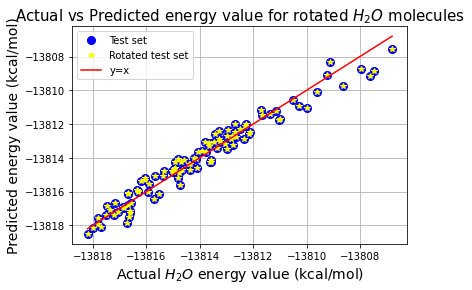

In [43]:
prediction_rotated = np.zeros(test_set_size)
for i in range(test_set_size):
    x1,x2,x3 = test_set_rot[i]
    prediction_rotated[i] = net(x1, x2, x3)#[0]


prediction_rotated = torch.tensor(prediction_rotated)

x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
print(min(torch.cat((test_labels,prediction_rotated),0)))
y = x
plt.plot(test_labels*var_lab+mean_lab,prediction*var_lab+mean_lab, 'o', color='blue', label = 'Test set',markersize=8)
plt.plot(test_labels*var_lab+mean_lab,prediction_rotated*var_lab+mean_lab, '*', color='yellow', label = 'Rotated test set')

plt.plot(x,y, color='red',label = 'y=x')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual $H_2O$ energy value (kcal/mol)',fontsize=14)
plt.ylabel('Predicted energy value (kcal/mol)',fontsize=14)
plt.title('Actual vs Predicted energy value for rotated $H_2O$ molecules',fontsize=15)
plt.legend()
plt.savefig('rotated_predicted_energies_H2O_G_feat',bbox_inches='tight')
plt.show()


**<h1>Training on xyz coordinates**

In [108]:
N                        = 3         # number of atoms per molecule
number_of_features_xyz   = 3         # number of features for each atom
                                  
training_set_size    = data_size_H2O - test_set_size

#################################################################################
for i in range(np.shape(energies_water)[0]):  # Moving all oxygens to the origin!!!!!!
    coord = coordinates_water[N*i:N*(i+1),:]
    coord = coord - coord[2,:]                # moving the origin to the oxygen
    coordinates_water[N*i:N*(i+1),:] = coord
#################################################################################
    
    
# Computing variance and mean on the training data only!
coord_train = coordinates_water[:training_set_size,:]
var_train_xyz  = np.var(coord_train,axis=0)
mean_train_xyz = np.mean(coord_train,axis=0)


coordinates_water_norm = np.zeros((len(coordinates_water), number_of_features_xyz))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(coordinates_water)[0]):
    for j in range(1,np.shape(coordinates_water)[1]):  # omit first column since for our dataset x=0 always
        coordinates_water_norm[i,j] = (coordinates_water[i,j]-mean_train_xyz[j])/var_train_xyz[j]

data_set_xyz = np.vsplit(coordinates_water_norm,data_size_H2O)     # !!!!!!!!!!!!  change to coordinates_water_norm if you are normalising
data_set_xyz = torch.FloatTensor(data_set_xyz)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor


# labels same as before   
train_labels         = labels_norm[:training_set_size]
train_labels         = torch.FloatTensor(train_labels)
test_labels          = labels_norm[training_set_size:]
test_labels          = torch.FloatTensor(test_labels)

    
# Splitting the dataset into training and test set
training_set_xyz         = data_set_xyz[:training_set_size]
test_set_xyz             = data_set_xyz[training_set_size:]
#train and test labels same as before

#################################################################################
#Randomly rotating each molecule in the dataset around its oxygen
rotated_training_set_xyz= np.zeros((np.shape(training_set_xyz)))
for i in range(training_set_size):
    coord = training_set_xyz[N*i:N*(i+1),:]
    coord = np.transpose(coord)
    A = random_rotation_matrix()
    rotated_training_set_xyz[N*i:N*(i+1),:] = np.transpose(rotate_data(A,coord))
print(np.shape(rotated_training_set_xyz))
rotated_training_set_xyz = torch.FloatTensor(rotated_training_set_xyz)
training_set_xyz = rotated_training_set_xyz
##################################################################################


#Dataset
dataset_xyz = TensorDataset(training_set_xyz, train_labels)

# Creating the batches
dataloader_xyz = torch.utils.data.DataLoader(dataset_xyz, batch_size=300, #300,
                                           shuffle=False, num_workers=2, drop_last=False) 


(900, 3, 3)


**<h2>Training new neural net on xyz coordinates**

In [118]:
net_xyz = BPNN_H2O(3)    # 3 features (x,y and z)

In [119]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net_xyz.parameters(), lr=0.005) #0.0001)#0.005)
#torch.optim.LBFGS(net.parameters(), lr=0.001, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, line_search_fn=None)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
nepochs = 20000

train_loss_xyz = np.zeros(nepochs)
test_loss_xyz = np.zeros(nepochs)

train_acc_xyz = np.zeros(nepochs)
test_acc_xyz = np.zeros(nepochs)

#===========================================================================
for epoch in range(nepochs):          # loop over the dataset multiple times
#===========================================================================
    
    running_loss_xyz = 0.0                #  Initialise losses at the start of each epoch 
    epoch_train_loss_xyz = 0.0             
    epoch_test_loss_xyz = 0.0
    
    
    counter = 0                               # ranges from 0 to the number of elements in each batch 
                                              # eg if we have 900 train. ex. and 25 batches, there will
                                              # be 36 elements in each batch.
    #---------------------------------------
    for i, data in enumerate(dataloader_xyz, 0):  # scan the whole dataset in each epoch, batch by batch (i ranges over batches)
    #---------------------------------------
        inputs, labels = data                 # get the inputs; data is a list of [inputs, labels]
        # zero the parameter gradients
        optimizer.zero_grad()                 # Calling .backward() mutiple times accumulates the gradient (by addition) 
                                              # for each parameter. This is why you should call optimizer.zero_grad() 
                                              # after each .step() call. 

        # forward + backward + optimize
        
        
        outputs = torch.zeros(np.shape(inputs)[0])
        for j in range(np.shape(inputs)[0]):
            outputs[j] = net_xyz(inputs[j][0],inputs[j][1],inputs[j][2])  # The net is designed to take a (3 x num_features)
            # tensor as an input, so when we are doing batch gd, we do a loop over all elements of the batch to create an
            # output vector with as many elements as the batch size. If our net was designed to take one row as input we 
            # wouldn't have needed the for loop, we could have had a vectorised implementation, i.e. outputs = net(inputs)
                       
            
        loss = criterion(outputs, labels) # a single value, same as loss.item(), which is the mean loss for each mini-batch
        loss.backward()                   # performs one back-propagation step 
        optimizer.step()                  # update the network parameters (perform an update step)

        # print statistics
        running_loss_xyz += loss.item()        # loss.item() contains loss of entire mini-batch, divided by the batch size, i.e. mean
                                           # we accumulate this loss over as many mini-batches as we like until we set it to zero after printing it
        epoch_train_loss_xyz += loss.item()    # cumulative loss for each epoch (sum of mean loss for all mini-batches)
                                           # so we ve divided here by the number of train. ex. in one mini-batch (mean)
                                           # thus all we need to do at the end of the epoch is divide by the number of mini-batches
        
        net_test_set_xyz = torch.zeros(np.shape(test_set_xyz)[0]) # outputs(predictions) of network if we input the test set
        with torch.no_grad():                             # The wrapper with torch.no_grad() temporarily sets all of 
                                                          # the requires_grad flags to false, i.e. makes all the 
                                                          # operations in the block have no gradients
            for k in range(np.shape(test_set_xyz)[0]):
                    net_test_set_xyz[k] = net_xyz(test_set_xyz[k][0],test_set_xyz[k][1],test_set_xyz[k][2])
            epoch_test_loss_xyz += criterion(net_test_set_xyz, test_labels).item() # sum test mean batch losses throughout epoch          
        if i % 10 == 0:    # print average loss every 10 mini-batches
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss_xyz/10))
            running_loss_xyz = 0.0
        counter += 1
        #------------------------------------       
    # Now we have added up the loss (both for training and test set) over all mini batches     
    train_loss_xyz[epoch] = epoch_train_loss_xyz/counter   # divide by number or training examples in one batch 
                                                           # to obtain average training loss for each epoch
#     if (abs((test_loss_xyz[epoch] - test_loss_xyz[epoch - 1])/test_loss_xyz[epoch - 1])< 0.1):
#         break
    test_loss_xyz[epoch] = epoch_test_loss_xyz/counter
    epoch_train_loss_xyz = 0.0
    epoch_test_loss_xyz = 0.0

#=================================================================================
    
print('Finished Training')

[1,     1] loss: 0.2476308107
[2,     1] loss: 0.2077746630
[3,     1] loss: 0.1727546811
[4,     1] loss: 0.1423677444
[5,     1] loss: 0.1163555026
[6,     1] loss: 0.0943756282
[7,     1] loss: 0.0760682583
[8,     1] loss: 0.0610760093
[9,     1] loss: 0.0490364134
[10,     1] loss: 0.0395802826
[11,     1] loss: 0.0323382020
[12,     1] loss: 0.0269487113
[13,     1] loss: 0.0230655417
[14,     1] loss: 0.0203642860
[15,     1] loss: 0.0185493276
[16,     1] loss: 0.0173612043
[17,     1] loss: 0.0165836990
[18,     1] loss: 0.0160489574
[19,     1] loss: 0.0156386137
[20,     1] loss: 0.0152796030
[21,     1] loss: 0.0149354309
[22,     1] loss: 0.0145949095
[23,     1] loss: 0.0142611817
[24,     1] loss: 0.0139429137
[25,     1] loss: 0.0136485711
[26,     1] loss: 0.0133835569
[27,     1] loss: 0.0131495774
[28,     1] loss: 0.0129452333
[29,     1] loss: 0.0127671987
[30,     1] loss: 0.0126113594
[31,     1] loss: 0.0124736801
[32,     1] loss: 0.0123507261
[33,     1] loss:

[261,     1] loss: 0.0112064339
[262,     1] loss: 0.0112065367
[263,     1] loss: 0.0112066410
[264,     1] loss: 0.0112067439
[265,     1] loss: 0.0112068459
[266,     1] loss: 0.0112069473
[267,     1] loss: 0.0112070464
[268,     1] loss: 0.0112071469
[269,     1] loss: 0.0112072445
[270,     1] loss: 0.0112073414
[271,     1] loss: 0.0112074398
[272,     1] loss: 0.0112075351
[273,     1] loss: 0.0112076305
[274,     1] loss: 0.0112077229
[275,     1] loss: 0.0112078145
[276,     1] loss: 0.0112079076
[277,     1] loss: 0.0112079963
[278,     1] loss: 0.0112080865
[279,     1] loss: 0.0112081729
[280,     1] loss: 0.0112082593
[281,     1] loss: 0.0112083457
[282,     1] loss: 0.0112084277
[283,     1] loss: 0.0112085104
[284,     1] loss: 0.0112085916
[285,     1] loss: 0.0112086706
[286,     1] loss: 0.0112087481
[287,     1] loss: 0.0112088226
[288,     1] loss: 0.0112088978
[289,     1] loss: 0.0112089701
[290,     1] loss: 0.0112090416
[291,     1] loss: 0.0112091117
[292,   

[518,     1] loss: 0.0109169081
[519,     1] loss: 0.0109127425
[520,     1] loss: 0.0109085962
[521,     1] loss: 0.0109044723
[522,     1] loss: 0.0109003700
[523,     1] loss: 0.0108962908
[524,     1] loss: 0.0108922370
[525,     1] loss: 0.0108882062
[526,     1] loss: 0.0108842023
[527,     1] loss: 0.0108802222
[528,     1] loss: 0.0108762704
[529,     1] loss: 0.0108723409
[530,     1] loss: 0.0108684413
[531,     1] loss: 0.0108645678
[532,     1] loss: 0.0108607203
[533,     1] loss: 0.0108569033
[534,     1] loss: 0.0108531140
[535,     1] loss: 0.0108493537
[536,     1] loss: 0.0108456217
[537,     1] loss: 0.0108419217
[538,     1] loss: 0.0108382516
[539,     1] loss: 0.0108346164
[540,     1] loss: 0.0108310141
[541,     1] loss: 0.0108274460
[542,     1] loss: 0.0108239137
[543,     1] loss: 0.0108204193
[544,     1] loss: 0.0108169630
[545,     1] loss: 0.0108135477
[546,     1] loss: 0.0108101733
[547,     1] loss: 0.0108068399
[548,     1] loss: 0.0108035535
[549,   

[775,     1] loss: 0.0106100887
[776,     1] loss: 0.0106095836
[777,     1] loss: 0.0106090799
[778,     1] loss: 0.0106085740
[779,     1] loss: 0.0106080651
[780,     1] loss: 0.0106075563
[781,     1] loss: 0.0106070451
[782,     1] loss: 0.0106065333
[783,     1] loss: 0.0106060199
[784,     1] loss: 0.0106055051
[785,     1] loss: 0.0106049895
[786,     1] loss: 0.0106044710
[787,     1] loss: 0.0106039517
[788,     1] loss: 0.0106034301
[789,     1] loss: 0.0106029093
[790,     1] loss: 0.0106023856
[791,     1] loss: 0.0106018595
[792,     1] loss: 0.0106013335
[793,     1] loss: 0.0106008053
[794,     1] loss: 0.0106002748
[795,     1] loss: 0.0105997443
[796,     1] loss: 0.0105992109
[797,     1] loss: 0.0105986774
[798,     1] loss: 0.0105981410
[799,     1] loss: 0.0105976038
[800,     1] loss: 0.0105970643
[801,     1] loss: 0.0105965234
[802,     1] loss: 0.0105959810
[803,     1] loss: 0.0105954371
[804,     1] loss: 0.0105948918
[805,     1] loss: 0.0105943441
[806,   

[1031,     1] loss: 0.0104490615
[1032,     1] loss: 0.0104484849
[1033,     1] loss: 0.0104479134
[1034,     1] loss: 0.0104473457
[1035,     1] loss: 0.0104467839
[1036,     1] loss: 0.0104462259
[1037,     1] loss: 0.0104456738
[1038,     1] loss: 0.0104451254
[1039,     1] loss: 0.0104445852
[1040,     1] loss: 0.0104440473
[1041,     1] loss: 0.0104435168
[1042,     1] loss: 0.0104429916
[1043,     1] loss: 0.0104424715
[1044,     1] loss: 0.0104419582
[1045,     1] loss: 0.0104414515
[1046,     1] loss: 0.0104409501
[1047,     1] loss: 0.0104404546
[1048,     1] loss: 0.0104399659
[1049,     1] loss: 0.0104394831
[1050,     1] loss: 0.0104390070
[1051,     1] loss: 0.0104385361
[1052,     1] loss: 0.0104380719
[1053,     1] loss: 0.0104376152
[1054,     1] loss: 0.0104371645
[1055,     1] loss: 0.0104367197
[1056,     1] loss: 0.0104362823
[1057,     1] loss: 0.0104358509
[1058,     1] loss: 0.0104354262
[1059,     1] loss: 0.0104350068
[1060,     1] loss: 0.0104345940
[1061,    

[1280,     1] loss: 0.0104098968
[1281,     1] loss: 0.0104099572
[1282,     1] loss: 0.0104100160
[1283,     1] loss: 0.0104100749
[1284,     1] loss: 0.0104101345
[1285,     1] loss: 0.0104101934
[1286,     1] loss: 0.0104102530
[1287,     1] loss: 0.0104103118
[1288,     1] loss: 0.0104103714
[1289,     1] loss: 0.0104104310
[1290,     1] loss: 0.0104104899
[1291,     1] loss: 0.0104105495
[1292,     1] loss: 0.0104106084
[1293,     1] loss: 0.0104106672
[1294,     1] loss: 0.0104107268
[1295,     1] loss: 0.0104107857
[1296,     1] loss: 0.0104108438
[1297,     1] loss: 0.0104109034
[1298,     1] loss: 0.0104109615
[1299,     1] loss: 0.0104110196
[1300,     1] loss: 0.0104110777
[1301,     1] loss: 0.0104111351
[1302,     1] loss: 0.0104111940
[1303,     1] loss: 0.0104112513
[1304,     1] loss: 0.0104113080
[1305,     1] loss: 0.0104113661
[1306,     1] loss: 0.0104114227
[1307,     1] loss: 0.0104114786
[1308,     1] loss: 0.0104115367
[1309,     1] loss: 0.0104115918
[1310,    

[1529,     1] loss: 0.0104045391
[1530,     1] loss: 0.0104043677
[1531,     1] loss: 0.0104041941
[1532,     1] loss: 0.0104040168
[1533,     1] loss: 0.0104038402
[1534,     1] loss: 0.0104036614
[1535,     1] loss: 0.0104034796
[1536,     1] loss: 0.0104032971
[1537,     1] loss: 0.0104031108
[1538,     1] loss: 0.0104029246
[1539,     1] loss: 0.0104027346
[1540,     1] loss: 0.0104025431
[1541,     1] loss: 0.0104023516
[1542,     1] loss: 0.0104021549
[1543,     1] loss: 0.0104019575
[1544,     1] loss: 0.0104017593
[1545,     1] loss: 0.0104015589
[1546,     1] loss: 0.0104013547
[1547,     1] loss: 0.0104011491
[1548,     1] loss: 0.0104009435
[1549,     1] loss: 0.0104007334
[1550,     1] loss: 0.0104005203
[1551,     1] loss: 0.0104003064
[1552,     1] loss: 0.0104000911
[1553,     1] loss: 0.0103998728
[1554,     1] loss: 0.0103996523
[1555,     1] loss: 0.0103994302
[1556,     1] loss: 0.0103992060
[1557,     1] loss: 0.0103989787
[1558,     1] loss: 0.0103987500
[1559,    

[1778,     1] loss: 0.0102573067
[1779,     1] loss: 0.0102562040
[1780,     1] loss: 0.0102550983
[1781,     1] loss: 0.0102539949
[1782,     1] loss: 0.0102528900
[1783,     1] loss: 0.0102517836
[1784,     1] loss: 0.0102506772
[1785,     1] loss: 0.0102495715
[1786,     1] loss: 0.0102484651
[1787,     1] loss: 0.0102473587
[1788,     1] loss: 0.0102462530
[1789,     1] loss: 0.0102451466
[1790,     1] loss: 0.0102440409
[1791,     1] loss: 0.0102429368
[1792,     1] loss: 0.0102418326
[1793,     1] loss: 0.0102407292
[1794,     1] loss: 0.0102396272
[1795,     1] loss: 0.0102385253
[1796,     1] loss: 0.0102374263
[1797,     1] loss: 0.0102363266
[1798,     1] loss: 0.0102352299
[1799,     1] loss: 0.0102341339
[1800,     1] loss: 0.0102330402
[1801,     1] loss: 0.0102319479
[1802,     1] loss: 0.0102308579
[1803,     1] loss: 0.0102297686
[1804,     1] loss: 0.0102286823
[1805,     1] loss: 0.0102275990
[1806,     1] loss: 0.0102265172
[1807,     1] loss: 0.0102254376
[1808,    

[2027,     1] loss: 0.0100239933
[2028,     1] loss: 0.0100234501
[2029,     1] loss: 0.0100229308
[2030,     1] loss: 0.0100224338
[2031,     1] loss: 0.0100219585
[2032,     1] loss: 0.0100215040
[2033,     1] loss: 0.0100210682
[2034,     1] loss: 0.0100206487
[2035,     1] loss: 0.0100202464
[2036,     1] loss: 0.0100198582
[2037,     1] loss: 0.0100194819
[2038,     1] loss: 0.0100191198
[2039,     1] loss: 0.0100187674
[2040,     1] loss: 0.0100184269
[2041,     1] loss: 0.0100180946
[2042,     1] loss: 0.0100177713
[2043,     1] loss: 0.0100174539
[2044,     1] loss: 0.0100171439
[2045,     1] loss: 0.0100168392
[2046,     1] loss: 0.0100165412
[2047,     1] loss: 0.0100162469
[2048,     1] loss: 0.0100159578
[2049,     1] loss: 0.0100156724
[2050,     1] loss: 0.0100153901
[2051,     1] loss: 0.0100151114
[2052,     1] loss: 0.0100148350
[2053,     1] loss: 0.0100145601
[2054,     1] loss: 0.0100142874
[2055,     1] loss: 0.0100140162
[2056,     1] loss: 0.0100137472
[2057,    

[2276,     1] loss: 0.0099600419
[2277,     1] loss: 0.0099597640
[2278,     1] loss: 0.0099594854
[2279,     1] loss: 0.0099592067
[2280,     1] loss: 0.0099589273
[2281,     1] loss: 0.0099586464
[2282,     1] loss: 0.0099583648
[2283,     1] loss: 0.0099580824
[2284,     1] loss: 0.0099577971
[2285,     1] loss: 0.0099575132
[2286,     1] loss: 0.0099572286
[2287,     1] loss: 0.0099569432
[2288,     1] loss: 0.0099566557
[2289,     1] loss: 0.0099563688
[2290,     1] loss: 0.0099560797
[2291,     1] loss: 0.0099557899
[2292,     1] loss: 0.0099554993
[2293,     1] loss: 0.0099552095
[2294,     1] loss: 0.0099549174
[2295,     1] loss: 0.0099546246
[2296,     1] loss: 0.0099543318
[2297,     1] loss: 0.0099540368
[2298,     1] loss: 0.0099537432
[2299,     1] loss: 0.0099534467
[2300,     1] loss: 0.0099531509
[2301,     1] loss: 0.0099528529
[2302,     1] loss: 0.0099525556
[2303,     1] loss: 0.0099522568
[2304,     1] loss: 0.0099519573
[2305,     1] loss: 0.0099516585
[2306,    

[2525,     1] loss: 0.0098956957
[2526,     1] loss: 0.0098955512
[2527,     1] loss: 0.0098954082
[2528,     1] loss: 0.0098952658
[2529,     1] loss: 0.0098951235
[2530,     1] loss: 0.0098949827
[2531,     1] loss: 0.0098948434
[2532,     1] loss: 0.0098947071
[2533,     1] loss: 0.0098945692
[2534,     1] loss: 0.0098944336
[2535,     1] loss: 0.0098943010
[2536,     1] loss: 0.0098941669
[2537,     1] loss: 0.0098940350
[2538,     1] loss: 0.0098939054
[2539,     1] loss: 0.0098937750
[2540,     1] loss: 0.0098936468
[2541,     1] loss: 0.0098935194
[2542,     1] loss: 0.0098933935
[2543,     1] loss: 0.0098932691
[2544,     1] loss: 0.0098931454
[2545,     1] loss: 0.0098930232
[2546,     1] loss: 0.0098929018
[2547,     1] loss: 0.0098927826
[2548,     1] loss: 0.0098926641
[2549,     1] loss: 0.0098925456
[2550,     1] loss: 0.0098924287
[2551,     1] loss: 0.0098923139
[2552,     1] loss: 0.0098921999
[2553,     1] loss: 0.0098920874
[2554,     1] loss: 0.0098919764
[2555,    

[2774,     1] loss: 0.0098850869
[2775,     1] loss: 0.0098850563
[2776,     1] loss: 0.0098850258
[2777,     1] loss: 0.0098849952
[2778,     1] loss: 0.0098849624
[2779,     1] loss: 0.0098849311
[2780,     1] loss: 0.0098848976
[2781,     1] loss: 0.0098848671
[2782,     1] loss: 0.0098848328
[2783,     1] loss: 0.0098848000
[2784,     1] loss: 0.0098847657
[2785,     1] loss: 0.0098847315
[2786,     1] loss: 0.0098846965
[2787,     1] loss: 0.0098846622
[2788,     1] loss: 0.0098846272
[2789,     1] loss: 0.0098845907
[2790,     1] loss: 0.0098845556
[2791,     1] loss: 0.0098845191
[2792,     1] loss: 0.0098844834
[2793,     1] loss: 0.0098844454
[2794,     1] loss: 0.0098844096
[2795,     1] loss: 0.0098843724
[2796,     1] loss: 0.0098843336
[2797,     1] loss: 0.0098842964
[2798,     1] loss: 0.0098842569
[2799,     1] loss: 0.0098842174
[2800,     1] loss: 0.0098841801
[2801,     1] loss: 0.0098841406
[2802,     1] loss: 0.0098841004
[2803,     1] loss: 0.0098840602
[2804,    

[3023,     1] loss: 0.0098723143
[3024,     1] loss: 0.0098722599
[3025,     1] loss: 0.0098722056
[3026,     1] loss: 0.0098721489
[3027,     1] loss: 0.0098720953
[3028,     1] loss: 0.0098720402
[3029,     1] loss: 0.0098719850
[3030,     1] loss: 0.0098719314
[3031,     1] loss: 0.0098718747
[3032,     1] loss: 0.0098718196
[3033,     1] loss: 0.0098717660
[3034,     1] loss: 0.0098717101
[3035,     1] loss: 0.0098716550
[3036,     1] loss: 0.0098716021
[3037,     1] loss: 0.0098715454
[3038,     1] loss: 0.0098714918
[3039,     1] loss: 0.0098714359
[3040,     1] loss: 0.0098713808
[3041,     1] loss: 0.0098713264
[3042,     1] loss: 0.0098712720
[3043,     1] loss: 0.0098712161
[3044,     1] loss: 0.0098711625
[3045,     1] loss: 0.0098711066
[3046,     1] loss: 0.0098710515
[3047,     1] loss: 0.0098709978
[3048,     1] loss: 0.0098709434
[3049,     1] loss: 0.0098708883
[3050,     1] loss: 0.0098708346
[3051,     1] loss: 0.0098707795
[3052,     1] loss: 0.0098707244
[3053,    

[3272,     1] loss: 0.0098608956
[3273,     1] loss: 0.0098608956
[3274,     1] loss: 0.0098608948
[3275,     1] loss: 0.0098608948
[3276,     1] loss: 0.0098608971
[3277,     1] loss: 0.0098608993
[3278,     1] loss: 0.0098609038
[3279,     1] loss: 0.0098609082
[3280,     1] loss: 0.0098609127
[3281,     1] loss: 0.0098609194
[3282,     1] loss: 0.0098609261
[3283,     1] loss: 0.0098609343
[3284,     1] loss: 0.0098609425
[3285,     1] loss: 0.0098609537
[3286,     1] loss: 0.0098609641
[3287,     1] loss: 0.0098609746
[3288,     1] loss: 0.0098609872
[3289,     1] loss: 0.0098609999
[3290,     1] loss: 0.0098610140
[3291,     1] loss: 0.0098610289
[3292,     1] loss: 0.0098610446
[3293,     1] loss: 0.0098610617
[3294,     1] loss: 0.0098610789
[3295,     1] loss: 0.0098610975
[3296,     1] loss: 0.0098611169
[3297,     1] loss: 0.0098611362
[3298,     1] loss: 0.0098611578
[3299,     1] loss: 0.0098611794
[3300,     1] loss: 0.0098612025
[3301,     1] loss: 0.0098612249
[3302,    

[3521,     1] loss: 0.0098710798
[3522,     1] loss: 0.0098711006
[3523,     1] loss: 0.0098711208
[3524,     1] loss: 0.0098711409
[3525,     1] loss: 0.0098711602
[3526,     1] loss: 0.0098711811
[3527,     1] loss: 0.0098712005
[3528,     1] loss: 0.0098712191
[3529,     1] loss: 0.0098712377
[3530,     1] loss: 0.0098712556
[3531,     1] loss: 0.0098712742
[3532,     1] loss: 0.0098712921
[3533,     1] loss: 0.0098713085
[3534,     1] loss: 0.0098713271
[3535,     1] loss: 0.0098713428
[3536,     1] loss: 0.0098713599
[3537,     1] loss: 0.0098713756
[3538,     1] loss: 0.0098713905
[3539,     1] loss: 0.0098714061
[3540,     1] loss: 0.0098714218
[3541,     1] loss: 0.0098714367
[3542,     1] loss: 0.0098714516
[3543,     1] loss: 0.0098714642
[3544,     1] loss: 0.0098714791
[3545,     1] loss: 0.0098714933
[3546,     1] loss: 0.0098715052
[3547,     1] loss: 0.0098715194
[3548,     1] loss: 0.0098715313
[3549,     1] loss: 0.0098715439
[3550,     1] loss: 0.0098715566
[3551,    

[3770,     1] loss: 0.0098685287
[3771,     1] loss: 0.0098684967
[3772,     1] loss: 0.0098684639
[3773,     1] loss: 0.0098684311
[3774,     1] loss: 0.0098683983
[3775,     1] loss: 0.0098683640
[3776,     1] loss: 0.0098683313
[3777,     1] loss: 0.0098682985
[3778,     1] loss: 0.0098682657
[3779,     1] loss: 0.0098682314
[3780,     1] loss: 0.0098681979
[3781,     1] loss: 0.0098681644
[3782,     1] loss: 0.0098681301
[3783,     1] loss: 0.0098680966
[3784,     1] loss: 0.0098680638
[3785,     1] loss: 0.0098680288
[3786,     1] loss: 0.0098679930
[3787,     1] loss: 0.0098679602
[3788,     1] loss: 0.0098679252
[3789,     1] loss: 0.0098678902
[3790,     1] loss: 0.0098678559
[3791,     1] loss: 0.0098678209
[3792,     1] loss: 0.0098677859
[3793,     1] loss: 0.0098677523
[3794,     1] loss: 0.0098677166
[3795,     1] loss: 0.0098676808
[3796,     1] loss: 0.0098676458
[3797,     1] loss: 0.0098676093
[3798,     1] loss: 0.0098675750
[3799,     1] loss: 0.0098675393
[3800,    

[4019,     1] loss: 0.0098576769
[4020,     1] loss: 0.0098576248
[4021,     1] loss: 0.0098575734
[4022,     1] loss: 0.0098575212
[4023,     1] loss: 0.0098574676
[4024,     1] loss: 0.0098574162
[4025,     1] loss: 0.0098573647
[4026,     1] loss: 0.0098573118
[4027,     1] loss: 0.0098572597
[4028,     1] loss: 0.0098572068
[4029,     1] loss: 0.0098571546
[4030,     1] loss: 0.0098571017
[4031,     1] loss: 0.0098570481
[4032,     1] loss: 0.0098569967
[4033,     1] loss: 0.0098569445
[4034,     1] loss: 0.0098568916
[4035,     1] loss: 0.0098568380
[4036,     1] loss: 0.0098567866
[4037,     1] loss: 0.0098567329
[4038,     1] loss: 0.0098566800
[4039,     1] loss: 0.0098566271
[4040,     1] loss: 0.0098565742
[4041,     1] loss: 0.0098565213
[4042,     1] loss: 0.0098564684
[4043,     1] loss: 0.0098564140
[4044,     1] loss: 0.0098563626
[4045,     1] loss: 0.0098563090
[4046,     1] loss: 0.0098562554
[4047,     1] loss: 0.0098562010
[4048,     1] loss: 0.0098561488
[4049,    

[4268,     1] loss: 0.0098434947
[4269,     1] loss: 0.0098434336
[4270,     1] loss: 0.0098433733
[4271,     1] loss: 0.0098433137
[4272,     1] loss: 0.0098432519
[4273,     1] loss: 0.0098431915
[4274,     1] loss: 0.0098431304
[4275,     1] loss: 0.0098430701
[4276,     1] loss: 0.0098430090
[4277,     1] loss: 0.0098429486
[4278,     1] loss: 0.0098428868
[4279,     1] loss: 0.0098428264
[4280,     1] loss: 0.0098427661
[4281,     1] loss: 0.0098427050
[4282,     1] loss: 0.0098426454
[4283,     1] loss: 0.0098425843
[4284,     1] loss: 0.0098425232
[4285,     1] loss: 0.0098424628
[4286,     1] loss: 0.0098424025
[4287,     1] loss: 0.0098423414
[4288,     1] loss: 0.0098422803
[4289,     1] loss: 0.0098422192
[4290,     1] loss: 0.0098421581
[4291,     1] loss: 0.0098420978
[4292,     1] loss: 0.0098420367
[4293,     1] loss: 0.0098419756
[4294,     1] loss: 0.0098419152
[4295,     1] loss: 0.0098418541
[4296,     1] loss: 0.0098417930
[4297,     1] loss: 0.0098417327
[4298,    

[4517,     1] loss: 0.0098281577
[4518,     1] loss: 0.0098280959
[4519,     1] loss: 0.0098280348
[4520,     1] loss: 0.0098279729
[4521,     1] loss: 0.0098279104
[4522,     1] loss: 0.0098278493
[4523,     1] loss: 0.0098277859
[4524,     1] loss: 0.0098277241
[4525,     1] loss: 0.0098276630
[4526,     1] loss: 0.0098276012
[4527,     1] loss: 0.0098275386
[4528,     1] loss: 0.0098274775
[4529,     1] loss: 0.0098274164
[4530,     1] loss: 0.0098273538
[4531,     1] loss: 0.0098272920
[4532,     1] loss: 0.0098272301
[4533,     1] loss: 0.0098271683
[4534,     1] loss: 0.0098271072
[4535,     1] loss: 0.0098270454
[4536,     1] loss: 0.0098269828
[4537,     1] loss: 0.0098269217
[4538,     1] loss: 0.0098268598
[4539,     1] loss: 0.0098267987
[4540,     1] loss: 0.0098267362
[4541,     1] loss: 0.0098266743
[4542,     1] loss: 0.0098266125
[4543,     1] loss: 0.0098265499
[4544,     1] loss: 0.0098264888
[4545,     1] loss: 0.0098264277
[4546,     1] loss: 0.0098263651
[4547,    

[4766,     1] loss: 0.0098128408
[4767,     1] loss: 0.0098127782
[4768,     1] loss: 0.0098127171
[4769,     1] loss: 0.0098126560
[4770,     1] loss: 0.0098125957
[4771,     1] loss: 0.0098125346
[4772,     1] loss: 0.0098124720
[4773,     1] loss: 0.0098124124
[4774,     1] loss: 0.0098123513
[4775,     1] loss: 0.0098122902
[4776,     1] loss: 0.0098122269
[4777,     1] loss: 0.0098121673
[4778,     1] loss: 0.0098121047
[4779,     1] loss: 0.0098120444
[4780,     1] loss: 0.0098119847
[4781,     1] loss: 0.0098119214
[4782,     1] loss: 0.0098118611
[4783,     1] loss: 0.0098118000
[4784,     1] loss: 0.0098117374
[4785,     1] loss: 0.0098116763
[4786,     1] loss: 0.0098116152
[4787,     1] loss: 0.0098115534
[4788,     1] loss: 0.0098114923
[4789,     1] loss: 0.0098114319
[4790,     1] loss: 0.0098113701
[4791,     1] loss: 0.0098113082
[4792,     1] loss: 0.0098112471
[4793,     1] loss: 0.0098111868
[4794,     1] loss: 0.0098111242
[4795,     1] loss: 0.0098110646
[4796,    

[5015,     1] loss: 0.0097975135
[5016,     1] loss: 0.0097974502
[5017,     1] loss: 0.0097973876
[5018,     1] loss: 0.0097973250
[5019,     1] loss: 0.0097972646
[5020,     1] loss: 0.0097972028
[5021,     1] loss: 0.0097971395
[5022,     1] loss: 0.0097970776
[5023,     1] loss: 0.0097970158
[5024,     1] loss: 0.0097969525
[5025,     1] loss: 0.0097968906
[5026,     1] loss: 0.0097968295
[5027,     1] loss: 0.0097967654
[5028,     1] loss: 0.0097967036
[5029,     1] loss: 0.0097966418
[5030,     1] loss: 0.0097965799
[5031,     1] loss: 0.0097965173
[5032,     1] loss: 0.0097964555
[5033,     1] loss: 0.0097963922
[5034,     1] loss: 0.0097963303
[5035,     1] loss: 0.0097962670
[5036,     1] loss: 0.0097962052
[5037,     1] loss: 0.0097961441
[5038,     1] loss: 0.0097960815
[5039,     1] loss: 0.0097960182
[5040,     1] loss: 0.0097959556
[5041,     1] loss: 0.0097958930
[5042,     1] loss: 0.0097958311
[5043,     1] loss: 0.0097957693
[5044,     1] loss: 0.0097957060
[5045,    

[5264,     1] loss: 0.0097817592
[5265,     1] loss: 0.0097816952
[5266,     1] loss: 0.0097816318
[5267,     1] loss: 0.0097815663
[5268,     1] loss: 0.0097815022
[5269,     1] loss: 0.0097814381
[5270,     1] loss: 0.0097813733
[5271,     1] loss: 0.0097813100
[5272,     1] loss: 0.0097812444
[5273,     1] loss: 0.0097811811
[5274,     1] loss: 0.0097811148
[5275,     1] loss: 0.0097810507
[5276,     1] loss: 0.0097809874
[5277,     1] loss: 0.0097809225
[5278,     1] loss: 0.0097808592
[5279,     1] loss: 0.0097807936
[5280,     1] loss: 0.0097807296
[5281,     1] loss: 0.0097806647
[5282,     1] loss: 0.0097806014
[5283,     1] loss: 0.0097805366
[5284,     1] loss: 0.0097804710
[5285,     1] loss: 0.0097804077
[5286,     1] loss: 0.0097803444
[5287,     1] loss: 0.0097802795
[5288,     1] loss: 0.0097802147
[5289,     1] loss: 0.0097801492
[5290,     1] loss: 0.0097800843
[5291,     1] loss: 0.0097800188
[5292,     1] loss: 0.0097799562
[5293,     1] loss: 0.0097798914
[5294,    

[5513,     1] loss: 0.0097656786
[5514,     1] loss: 0.0097656138
[5515,     1] loss: 0.0097655505
[5516,     1] loss: 0.0097654864
[5517,     1] loss: 0.0097654216
[5518,     1] loss: 0.0097653583
[5519,     1] loss: 0.0097652934
[5520,     1] loss: 0.0097652286
[5521,     1] loss: 0.0097651646
[5522,     1] loss: 0.0097650997
[5523,     1] loss: 0.0097650371
[5524,     1] loss: 0.0097649731
[5525,     1] loss: 0.0097649083
[5526,     1] loss: 0.0097648434
[5527,     1] loss: 0.0097647794
[5528,     1] loss: 0.0097647160
[5529,     1] loss: 0.0097646512
[5530,     1] loss: 0.0097645879
[5531,     1] loss: 0.0097645238
[5532,     1] loss: 0.0097644605
[5533,     1] loss: 0.0097643957
[5534,     1] loss: 0.0097643308
[5535,     1] loss: 0.0097642675
[5536,     1] loss: 0.0097642027
[5537,     1] loss: 0.0097641386
[5538,     1] loss: 0.0097640753
[5539,     1] loss: 0.0097640119
[5540,     1] loss: 0.0097639479
[5541,     1] loss: 0.0097638838
[5542,     1] loss: 0.0097638197
[5543,    

[5762,     1] loss: 0.0097499803
[5763,     1] loss: 0.0097499184
[5764,     1] loss: 0.0097498558
[5765,     1] loss: 0.0097497940
[5766,     1] loss: 0.0097497337
[5767,     1] loss: 0.0097496711
[5768,     1] loss: 0.0097496085
[5769,     1] loss: 0.0097495474
[5770,     1] loss: 0.0097494848
[5771,     1] loss: 0.0097494245
[5772,     1] loss: 0.0097493611
[5773,     1] loss: 0.0097493008
[5774,     1] loss: 0.0097492389
[5775,     1] loss: 0.0097491764
[5776,     1] loss: 0.0097491153
[5777,     1] loss: 0.0097490542
[5778,     1] loss: 0.0097489916
[5779,     1] loss: 0.0097489297
[5780,     1] loss: 0.0097488686
[5781,     1] loss: 0.0097488068
[5782,     1] loss: 0.0097487457
[5783,     1] loss: 0.0097486839
[5784,     1] loss: 0.0097486220
[5785,     1] loss: 0.0097485609
[5786,     1] loss: 0.0097484998
[5787,     1] loss: 0.0097484373
[5788,     1] loss: 0.0097483747
[5789,     1] loss: 0.0097483143
[5790,     1] loss: 0.0097482532
[5791,     1] loss: 0.0097481914
[5792,    

[6011,     1] loss: 0.0097348146
[6012,     1] loss: 0.0097347558
[6013,     1] loss: 0.0097346954
[6014,     1] loss: 0.0097346343
[6015,     1] loss: 0.0097345740
[6016,     1] loss: 0.0097345144
[6017,     1] loss: 0.0097344540
[6018,     1] loss: 0.0097343944
[6019,     1] loss: 0.0097343341
[6020,     1] loss: 0.0097342737
[6021,     1] loss: 0.0097342134
[6022,     1] loss: 0.0097341537
[6023,     1] loss: 0.0097340927
[6024,     1] loss: 0.0097340316
[6025,     1] loss: 0.0097339712
[6026,     1] loss: 0.0097339116
[6027,     1] loss: 0.0097338513
[6028,     1] loss: 0.0097337916
[6029,     1] loss: 0.0097337313
[6030,     1] loss: 0.0097336717
[6031,     1] loss: 0.0097336113
[6032,     1] loss: 0.0097335510
[6033,     1] loss: 0.0097334906
[6034,     1] loss: 0.0097334303
[6035,     1] loss: 0.0097333699
[6036,     1] loss: 0.0097333096
[6037,     1] loss: 0.0097332500
[6038,     1] loss: 0.0097331896
[6039,     1] loss: 0.0097331293
[6040,     1] loss: 0.0097330689
[6041,    

[6260,     1] loss: 0.0097198248
[6261,     1] loss: 0.0097197644
[6262,     1] loss: 0.0097197041
[6263,     1] loss: 0.0097196437
[6264,     1] loss: 0.0097195819
[6265,     1] loss: 0.0097195216
[6266,     1] loss: 0.0097194612
[6267,     1] loss: 0.0097194001
[6268,     1] loss: 0.0097193412
[6269,     1] loss: 0.0097192809
[6270,     1] loss: 0.0097192198
[6271,     1] loss: 0.0097191602
[6272,     1] loss: 0.0097190991
[6273,     1] loss: 0.0097190380
[6274,     1] loss: 0.0097189777
[6275,     1] loss: 0.0097189166
[6276,     1] loss: 0.0097188570
[6277,     1] loss: 0.0097187959
[6278,     1] loss: 0.0097187348
[6279,     1] loss: 0.0097186752
[6280,     1] loss: 0.0097186133
[6281,     1] loss: 0.0097185545
[6282,     1] loss: 0.0097184941
[6283,     1] loss: 0.0097184330
[6284,     1] loss: 0.0097183727
[6285,     1] loss: 0.0097183116
[6286,     1] loss: 0.0097182520
[6287,     1] loss: 0.0097181909
[6288,     1] loss: 0.0097181298
[6289,     1] loss: 0.0097180694
[6290,    

[6509,     1] loss: 0.0097045735
[6510,     1] loss: 0.0097045101
[6511,     1] loss: 0.0097044490
[6512,     1] loss: 0.0097043857
[6513,     1] loss: 0.0097043231
[6514,     1] loss: 0.0097042605
[6515,     1] loss: 0.0097041987
[6516,     1] loss: 0.0097041368
[6517,     1] loss: 0.0097040743
[6518,     1] loss: 0.0097040117
[6519,     1] loss: 0.0097039498
[6520,     1] loss: 0.0097038865
[6521,     1] loss: 0.0097038247
[6522,     1] loss: 0.0097037621
[6523,     1] loss: 0.0097036988
[6524,     1] loss: 0.0097036377
[6525,     1] loss: 0.0097035743
[6526,     1] loss: 0.0097035125
[6527,     1] loss: 0.0097034492
[6528,     1] loss: 0.0097033873
[6529,     1] loss: 0.0097033247
[6530,     1] loss: 0.0097032614
[6531,     1] loss: 0.0097031996
[6532,     1] loss: 0.0097031362
[6533,     1] loss: 0.0097030744
[6534,     1] loss: 0.0097030111
[6535,     1] loss: 0.0097029492
[6536,     1] loss: 0.0097028874
[6537,     1] loss: 0.0097028233
[6538,     1] loss: 0.0097027615
[6539,    

[6758,     1] loss: 0.0096887127
[6759,     1] loss: 0.0096886486
[6760,     1] loss: 0.0096885830
[6761,     1] loss: 0.0096885160
[6762,     1] loss: 0.0096884511
[6763,     1] loss: 0.0096883856
[6764,     1] loss: 0.0096883185
[6765,     1] loss: 0.0096882559
[6766,     1] loss: 0.0096881904
[6767,     1] loss: 0.0096881241
[6768,     1] loss: 0.0096880585
[6769,     1] loss: 0.0096879937
[6770,     1] loss: 0.0096879289
[6771,     1] loss: 0.0096878625
[6772,     1] loss: 0.0096877977
[6773,     1] loss: 0.0096877329
[6774,     1] loss: 0.0096876673
[6775,     1] loss: 0.0096876018
[6776,     1] loss: 0.0096875355
[6777,     1] loss: 0.0096874714
[6778,     1] loss: 0.0096874051
[6779,     1] loss: 0.0096873395
[6780,     1] loss: 0.0096872732
[6781,     1] loss: 0.0096872084
[6782,     1] loss: 0.0096871436
[6783,     1] loss: 0.0096870765
[6784,     1] loss: 0.0096870109
[6785,     1] loss: 0.0096869469
[6786,     1] loss: 0.0096868806
[6787,     1] loss: 0.0096868157
[6788,    

[7007,     1] loss: 0.0096720397
[7008,     1] loss: 0.0096719705
[7009,     1] loss: 0.0096719012
[7010,     1] loss: 0.0096718341
[7011,     1] loss: 0.0096717648
[7012,     1] loss: 0.0096716955
[7013,     1] loss: 0.0096716262
[7014,     1] loss: 0.0096715569
[7015,     1] loss: 0.0096714891
[7016,     1] loss: 0.0096714206
[7017,     1] loss: 0.0096713521
[7018,     1] loss: 0.0096712828
[7019,     1] loss: 0.0096712135
[7020,     1] loss: 0.0096711449
[7021,     1] loss: 0.0096710764
[7022,     1] loss: 0.0096710078
[7023,     1] loss: 0.0096709378
[7024,     1] loss: 0.0096708693
[7025,     1] loss: 0.0096707985
[7026,     1] loss: 0.0096707299
[7027,     1] loss: 0.0096706621
[7028,     1] loss: 0.0096705928
[7029,     1] loss: 0.0096705236
[7030,     1] loss: 0.0096704550
[7031,     1] loss: 0.0096703857
[7032,     1] loss: 0.0096703164
[7033,     1] loss: 0.0096702471
[7034,     1] loss: 0.0096701786
[7035,     1] loss: 0.0096701100
[7036,     1] loss: 0.0096700408
[7037,    

[7256,     1] loss: 0.0096544906
[7257,     1] loss: 0.0096544176
[7258,     1] loss: 0.0096543454
[7259,     1] loss: 0.0096542738
[7260,     1] loss: 0.0096542008
[7261,     1] loss: 0.0096541278
[7262,     1] loss: 0.0096540570
[7263,     1] loss: 0.0096539840
[7264,     1] loss: 0.0096539110
[7265,     1] loss: 0.0096538395
[7266,     1] loss: 0.0096537657
[7267,     1] loss: 0.0096536942
[7268,     1] loss: 0.0096536212
[7269,     1] loss: 0.0096535489
[7270,     1] loss: 0.0096534766
[7271,     1] loss: 0.0096534051
[7272,     1] loss: 0.0096533321
[7273,     1] loss: 0.0096532598
[7274,     1] loss: 0.0096531868
[7275,     1] loss: 0.0096531153
[7276,     1] loss: 0.0096530423
[7277,     1] loss: 0.0096529700
[7278,     1] loss: 0.0096528970
[7279,     1] loss: 0.0096528247
[7280,     1] loss: 0.0096527532
[7281,     1] loss: 0.0096526794
[7282,     1] loss: 0.0096526079
[7283,     1] loss: 0.0096525356
[7284,     1] loss: 0.0096524626
[7285,     1] loss: 0.0096523903
[7286,    

[7505,     1] loss: 0.0096361130
[7506,     1] loss: 0.0096360378
[7507,     1] loss: 0.0096359618
[7508,     1] loss: 0.0096358873
[7509,     1] loss: 0.0096358120
[7510,     1] loss: 0.0096357368
[7511,     1] loss: 0.0096356601
[7512,     1] loss: 0.0096355848
[7513,     1] loss: 0.0096355103
[7514,     1] loss: 0.0096354336
[7515,     1] loss: 0.0096353598
[7516,     1] loss: 0.0096352823
[7517,     1] loss: 0.0096352085
[7518,     1] loss: 0.0096351326
[7519,     1] loss: 0.0096350573
[7520,     1] loss: 0.0096349813
[7521,     1] loss: 0.0096349061
[7522,     1] loss: 0.0096348315
[7523,     1] loss: 0.0096347556
[7524,     1] loss: 0.0096346803
[7525,     1] loss: 0.0096346051
[7526,     1] loss: 0.0096345291
[7527,     1] loss: 0.0096344531
[7528,     1] loss: 0.0096343778
[7529,     1] loss: 0.0096343018
[7530,     1] loss: 0.0096342266
[7531,     1] loss: 0.0096341513
[7532,     1] loss: 0.0096340761
[7533,     1] loss: 0.0096339993
[7534,     1] loss: 0.0096339248
[7535,    

[7754,     1] loss: 0.0096170619
[7755,     1] loss: 0.0096169822
[7756,     1] loss: 0.0096169055
[7757,     1] loss: 0.0096168280
[7758,     1] loss: 0.0096167497
[7759,     1] loss: 0.0096166722
[7760,     1] loss: 0.0096165940
[7761,     1] loss: 0.0096165173
[7762,     1] loss: 0.0096164383
[7763,     1] loss: 0.0096163616
[7764,     1] loss: 0.0096162833
[7765,     1] loss: 0.0096162073
[7766,     1] loss: 0.0096161298
[7767,     1] loss: 0.0096160524
[7768,     1] loss: 0.0096159749
[7769,     1] loss: 0.0096158959
[7770,     1] loss: 0.0096158192
[7771,     1] loss: 0.0096157402
[7772,     1] loss: 0.0096156619
[7773,     1] loss: 0.0096155852
[7774,     1] loss: 0.0096155085
[7775,     1] loss: 0.0096154302
[7776,     1] loss: 0.0096153505
[7777,     1] loss: 0.0096152730
[7778,     1] loss: 0.0096151963
[7779,     1] loss: 0.0096151173
[7780,     1] loss: 0.0096150398
[7781,     1] loss: 0.0096149623
[7782,     1] loss: 0.0096148849
[7783,     1] loss: 0.0096148074
[7784,    

[8003,     1] loss: 0.0095975541
[8004,     1] loss: 0.0095974751
[8005,     1] loss: 0.0095973946
[8006,     1] loss: 0.0095973164
[8007,     1] loss: 0.0095972382
[8008,     1] loss: 0.0095971584
[8009,     1] loss: 0.0095970795
[8010,     1] loss: 0.0095970005
[8011,     1] loss: 0.0095969208
[8012,     1] loss: 0.0095968433
[8013,     1] loss: 0.0095967650
[8014,     1] loss: 0.0095966853
[8015,     1] loss: 0.0095966056
[8016,     1] loss: 0.0095965274
[8017,     1] loss: 0.0095964476
[8018,     1] loss: 0.0095963702
[8019,     1] loss: 0.0095962904
[8020,     1] loss: 0.0095962122
[8021,     1] loss: 0.0095961332
[8022,     1] loss: 0.0095960543
[8023,     1] loss: 0.0095959753
[8024,     1] loss: 0.0095958963
[8025,     1] loss: 0.0095958166
[8026,     1] loss: 0.0095957391
[8027,     1] loss: 0.0095956586
[8028,     1] loss: 0.0095955811
[8029,     1] loss: 0.0095955007
[8030,     1] loss: 0.0095954217
[8031,     1] loss: 0.0095953442
[8032,     1] loss: 0.0095952645
[8033,    

[8252,     1] loss: 0.0095778659
[8253,     1] loss: 0.0095777847
[8254,     1] loss: 0.0095777057
[8255,     1] loss: 0.0095776275
[8256,     1] loss: 0.0095775478
[8257,     1] loss: 0.0095774680
[8258,     1] loss: 0.0095773891
[8259,     1] loss: 0.0095773108
[8260,     1] loss: 0.0095772311
[8261,     1] loss: 0.0095771529
[8262,     1] loss: 0.0095770746
[8263,     1] loss: 0.0095769949
[8264,     1] loss: 0.0095769145
[8265,     1] loss: 0.0095768370
[8266,     1] loss: 0.0095767573
[8267,     1] loss: 0.0095766783
[8268,     1] loss: 0.0095766000
[8269,     1] loss: 0.0095765218
[8270,     1] loss: 0.0095764413
[8271,     1] loss: 0.0095763631
[8272,     1] loss: 0.0095762841
[8273,     1] loss: 0.0095762044
[8274,     1] loss: 0.0095761254
[8275,     1] loss: 0.0095760472
[8276,     1] loss: 0.0095759682
[8277,     1] loss: 0.0095758893
[8278,     1] loss: 0.0095758095
[8279,     1] loss: 0.0095757313
[8280,     1] loss: 0.0095756508
[8281,     1] loss: 0.0095755726
[8282,    

[8501,     1] loss: 0.0095583066
[8502,     1] loss: 0.0095582277
[8503,     1] loss: 0.0095581509
[8504,     1] loss: 0.0095580727
[8505,     1] loss: 0.0095579945
[8506,     1] loss: 0.0095579170
[8507,     1] loss: 0.0095578395
[8508,     1] loss: 0.0095577620
[8509,     1] loss: 0.0095576845
[8510,     1] loss: 0.0095576055
[8511,     1] loss: 0.0095575288
[8512,     1] loss: 0.0095574513
[8513,     1] loss: 0.0095573716
[8514,     1] loss: 0.0095572941
[8515,     1] loss: 0.0095572188
[8516,     1] loss: 0.0095571384
[8517,     1] loss: 0.0095570616
[8518,     1] loss: 0.0095569849
[8519,     1] loss: 0.0095569059
[8520,     1] loss: 0.0095568292
[8521,     1] loss: 0.0095567510
[8522,     1] loss: 0.0095566720
[8523,     1] loss: 0.0095565952
[8524,     1] loss: 0.0095565170
[8525,     1] loss: 0.0095564395
[8526,     1] loss: 0.0095563613
[8527,     1] loss: 0.0095562853
[8528,     1] loss: 0.0095562071
[8529,     1] loss: 0.0095561281
[8530,     1] loss: 0.0095560513
[8531,    

[8750,     1] loss: 0.0095392235
[8751,     1] loss: 0.0095391467
[8752,     1] loss: 0.0095390722
[8753,     1] loss: 0.0095389992
[8754,     1] loss: 0.0095389217
[8755,     1] loss: 0.0095388480
[8756,     1] loss: 0.0095387727
[8757,     1] loss: 0.0095386960
[8758,     1] loss: 0.0095386237
[8759,     1] loss: 0.0095385477
[8760,     1] loss: 0.0095384710
[8761,     1] loss: 0.0095383972
[8762,     1] loss: 0.0095383212
[8763,     1] loss: 0.0095382459
[8764,     1] loss: 0.0095381714
[8765,     1] loss: 0.0095380977
[8766,     1] loss: 0.0095380232
[8767,     1] loss: 0.0095379472
[8768,     1] loss: 0.0095378727
[8769,     1] loss: 0.0095377974
[8770,     1] loss: 0.0095377252
[8771,     1] loss: 0.0095376484
[8772,     1] loss: 0.0095375732
[8773,     1] loss: 0.0095374987
[8774,     1] loss: 0.0095374234
[8775,     1] loss: 0.0095373489
[8776,     1] loss: 0.0095372744
[8777,     1] loss: 0.0095371984
[8778,     1] loss: 0.0095371239
[8779,     1] loss: 0.0095370501
[8780,    

[8999,     1] loss: 0.0095210440
[9000,     1] loss: 0.0095209748
[9001,     1] loss: 0.0095209017
[9002,     1] loss: 0.0095208324
[9003,     1] loss: 0.0095207617
[9004,     1] loss: 0.0095206909
[9005,     1] loss: 0.0095206194
[9006,     1] loss: 0.0095205501
[9007,     1] loss: 0.0095204785
[9008,     1] loss: 0.0095204100
[9009,     1] loss: 0.0095203377
[9010,     1] loss: 0.0095202670
[9011,     1] loss: 0.0095201991
[9012,     1] loss: 0.0095201276
[9013,     1] loss: 0.0095200561
[9014,     1] loss: 0.0095199876
[9015,     1] loss: 0.0095199160
[9016,     1] loss: 0.0095198460
[9017,     1] loss: 0.0095197774
[9018,     1] loss: 0.0095197067
[9019,     1] loss: 0.0095196359
[9020,     1] loss: 0.0095195659
[9021,     1] loss: 0.0095194958
[9022,     1] loss: 0.0095194258
[9023,     1] loss: 0.0095193557
[9024,     1] loss: 0.0095192850
[9025,     1] loss: 0.0095192164
[9026,     1] loss: 0.0095191456
[9027,     1] loss: 0.0095190763
[9028,     1] loss: 0.0095190063
[9029,    

[9248,     1] loss: 0.0095042452
[9249,     1] loss: 0.0095041811
[9250,     1] loss: 0.0095041171
[9251,     1] loss: 0.0095040523
[9252,     1] loss: 0.0095039904
[9253,     1] loss: 0.0095039256
[9254,     1] loss: 0.0095038615
[9255,     1] loss: 0.0095037989
[9256,     1] loss: 0.0095037349
[9257,     1] loss: 0.0095036715
[9258,     1] loss: 0.0095036060
[9259,     1] loss: 0.0095035434
[9260,     1] loss: 0.0095034793
[9261,     1] loss: 0.0095034160
[9262,     1] loss: 0.0095033519
[9263,     1] loss: 0.0095032886
[9264,     1] loss: 0.0095032260
[9265,     1] loss: 0.0095031627
[9266,     1] loss: 0.0095030986
[9267,     1] loss: 0.0095030345
[9268,     1] loss: 0.0095029704
[9269,     1] loss: 0.0095029071
[9270,     1] loss: 0.0095028430
[9271,     1] loss: 0.0095027812
[9272,     1] loss: 0.0095027171
[9273,     1] loss: 0.0095026538
[9274,     1] loss: 0.0095025904
[9275,     1] loss: 0.0095025279
[9276,     1] loss: 0.0095024638
[9277,     1] loss: 0.0095023997
[9278,    

[9497,     1] loss: 0.0094892509
[9498,     1] loss: 0.0094891928
[9499,     1] loss: 0.0094891384
[9500,     1] loss: 0.0094890811
[9501,     1] loss: 0.0094890237
[9502,     1] loss: 0.0094889686
[9503,     1] loss: 0.0094889119
[9504,     1] loss: 0.0094888568
[9505,     1] loss: 0.0094887994
[9506,     1] loss: 0.0094887435
[9507,     1] loss: 0.0094886869
[9508,     1] loss: 0.0094886325
[9509,     1] loss: 0.0094885759
[9510,     1] loss: 0.0094885200
[9511,     1] loss: 0.0094884641
[9512,     1] loss: 0.0094884083
[9513,     1] loss: 0.0094883509
[9514,     1] loss: 0.0094882965
[9515,     1] loss: 0.0094882414
[9516,     1] loss: 0.0094881855
[9517,     1] loss: 0.0094881296
[9518,     1] loss: 0.0094880737
[9519,     1] loss: 0.0094880179
[9520,     1] loss: 0.0094879620
[9521,     1] loss: 0.0094879083
[9522,     1] loss: 0.0094878525
[9523,     1] loss: 0.0094877951
[9524,     1] loss: 0.0094877407
[9525,     1] loss: 0.0094876848
[9526,     1] loss: 0.0094876282
[9527,    

[9746,     1] loss: 0.0094761744
[9747,     1] loss: 0.0094761267
[9748,     1] loss: 0.0094760776
[9749,     1] loss: 0.0094760284
[9750,     1] loss: 0.0094759800
[9751,     1] loss: 0.0094759315
[9752,     1] loss: 0.0094758824
[9753,     1] loss: 0.0094758332
[9754,     1] loss: 0.0094757833
[9755,     1] loss: 0.0094757348
[9756,     1] loss: 0.0094756857
[9757,     1] loss: 0.0094756387
[9758,     1] loss: 0.0094755903
[9759,     1] loss: 0.0094755419
[9760,     1] loss: 0.0094754934
[9761,     1] loss: 0.0094754435
[9762,     1] loss: 0.0094753958
[9763,     1] loss: 0.0094753467
[9764,     1] loss: 0.0094752982
[9765,     1] loss: 0.0094752505
[9766,     1] loss: 0.0094752029
[9767,     1] loss: 0.0094751537
[9768,     1] loss: 0.0094751053
[9769,     1] loss: 0.0094750576
[9770,     1] loss: 0.0094750091
[9771,     1] loss: 0.0094749600
[9772,     1] loss: 0.0094749130
[9773,     1] loss: 0.0094748646
[9774,     1] loss: 0.0094748162
[9775,     1] loss: 0.0094747685
[9776,    

[9995,     1] loss: 0.0094647773
[9996,     1] loss: 0.0094647340
[9997,     1] loss: 0.0094646908
[9998,     1] loss: 0.0094646484
[9999,     1] loss: 0.0094646059
[10000,     1] loss: 0.0094645634
[10001,     1] loss: 0.0094645195
[10002,     1] loss: 0.0094644777
[10003,     1] loss: 0.0094644353
[10004,     1] loss: 0.0094643921
[10005,     1] loss: 0.0094643489
[10006,     1] loss: 0.0094643064
[10007,     1] loss: 0.0094642647
[10008,     1] loss: 0.0094642200
[10009,     1] loss: 0.0094641775
[10010,     1] loss: 0.0094641358
[10011,     1] loss: 0.0094640948
[10012,     1] loss: 0.0094640501
[10013,     1] loss: 0.0094640084
[10014,     1] loss: 0.0094639651
[10015,     1] loss: 0.0094639227
[10016,     1] loss: 0.0094638810
[10017,     1] loss: 0.0094638377
[10018,     1] loss: 0.0094637960
[10019,     1] loss: 0.0094637543
[10020,     1] loss: 0.0094637111
[10021,     1] loss: 0.0094636679
[10022,     1] loss: 0.0094636261
[10023,     1] loss: 0.0094635852
[10024,     1] loss

[10237,     1] loss: 0.0094549388
[10238,     1] loss: 0.0094549023
[10239,     1] loss: 0.0094548635
[10240,     1] loss: 0.0094548248
[10241,     1] loss: 0.0094547845
[10242,     1] loss: 0.0094547473
[10243,     1] loss: 0.0094547085
[10244,     1] loss: 0.0094546683
[10245,     1] loss: 0.0094546311
[10246,     1] loss: 0.0094545931
[10247,     1] loss: 0.0094545536
[10248,     1] loss: 0.0094545163
[10249,     1] loss: 0.0094544776
[10250,     1] loss: 0.0094544396
[10251,     1] loss: 0.0094544001
[10252,     1] loss: 0.0094543628
[10253,     1] loss: 0.0094543248
[10254,     1] loss: 0.0094542861
[10255,     1] loss: 0.0094542474
[10256,     1] loss: 0.0094542086
[10257,     1] loss: 0.0094541699
[10258,     1] loss: 0.0094541319
[10259,     1] loss: 0.0094540939
[10260,     1] loss: 0.0094540551
[10261,     1] loss: 0.0094540171
[10262,     1] loss: 0.0094539784
[10263,     1] loss: 0.0094539404
[10264,     1] loss: 0.0094539031
[10265,     1] loss: 0.0094538637
[10266,     1]

[10478,     1] loss: 0.0094460316
[10479,     1] loss: 0.0094459958
[10480,     1] loss: 0.0094459601
[10481,     1] loss: 0.0094459251
[10482,     1] loss: 0.0094458885
[10483,     1] loss: 0.0094458543
[10484,     1] loss: 0.0094458193
[10485,     1] loss: 0.0094457828
[10486,     1] loss: 0.0094457485
[10487,     1] loss: 0.0094457135
[10488,     1] loss: 0.0094456777
[10489,     1] loss: 0.0094456427
[10490,     1] loss: 0.0094456062
[10491,     1] loss: 0.0094455704
[10492,     1] loss: 0.0094455354
[10493,     1] loss: 0.0094455011
[10494,     1] loss: 0.0094454654
[10495,     1] loss: 0.0094454296
[10496,     1] loss: 0.0094453938
[10497,     1] loss: 0.0094453596
[10498,     1] loss: 0.0094453238
[10499,     1] loss: 0.0094452880
[10500,     1] loss: 0.0094452523
[10501,     1] loss: 0.0094452180
[10502,     1] loss: 0.0094451807
[10503,     1] loss: 0.0094451472
[10504,     1] loss: 0.0094451115
[10505,     1] loss: 0.0094450757
[10506,     1] loss: 0.0094450422
[10507,     1]

[10719,     1] loss: 0.0094377361
[10720,     1] loss: 0.0094377026
[10721,     1] loss: 0.0094376706
[10722,     1] loss: 0.0094376363
[10723,     1] loss: 0.0094376020
[10724,     1] loss: 0.0094375685
[10725,     1] loss: 0.0094375372
[10726,     1] loss: 0.0094375022
[10727,     1] loss: 0.0094374679
[10728,     1] loss: 0.0094374351
[10729,     1] loss: 0.0094374023
[10730,     1] loss: 0.0094373681
[10731,     1] loss: 0.0094373345
[10732,     1] loss: 0.0094373010
[10733,     1] loss: 0.0094372682
[10734,     1] loss: 0.0094372340
[10735,     1] loss: 0.0094372004
[10736,     1] loss: 0.0094371676
[10737,     1] loss: 0.0094371334
[10738,     1] loss: 0.0094370998
[10739,     1] loss: 0.0094370663
[10740,     1] loss: 0.0094370335
[10741,     1] loss: 0.0094369993
[10742,     1] loss: 0.0094369657
[10743,     1] loss: 0.0094369337
[10744,     1] loss: 0.0094368972
[10745,     1] loss: 0.0094368652
[10746,     1] loss: 0.0094368316
[10747,     1] loss: 0.0094367981
[10748,     1]

[10960,     1] loss: 0.0094297819
[10961,     1] loss: 0.0094297476
[10962,     1] loss: 0.0094297171
[10963,     1] loss: 0.0094296843
[10964,     1] loss: 0.0094296508
[10965,     1] loss: 0.0094296172
[10966,     1] loss: 0.0094295852
[10967,     1] loss: 0.0094295532
[10968,     1] loss: 0.0094295211
[10969,     1] loss: 0.0094294891
[10970,     1] loss: 0.0094294548
[10971,     1] loss: 0.0094294228
[10972,     1] loss: 0.0094293922
[10973,     1] loss: 0.0094293572
[10974,     1] loss: 0.0094293252
[10975,     1] loss: 0.0094292939
[10976,     1] loss: 0.0094292603
[10977,     1] loss: 0.0094292276
[10978,     1] loss: 0.0094291940
[10979,     1] loss: 0.0094291620
[10980,     1] loss: 0.0094291285
[10981,     1] loss: 0.0094290964
[10982,     1] loss: 0.0094290644
[10983,     1] loss: 0.0094290316
[10984,     1] loss: 0.0094289973
[10985,     1] loss: 0.0094289660
[10986,     1] loss: 0.0094289333
[10987,     1] loss: 0.0094289005
[10988,     1] loss: 0.0094288684
[10989,     1]

[11201,     1] loss: 0.0094219081
[11202,     1] loss: 0.0094218746
[11203,     1] loss: 0.0094218425
[11204,     1] loss: 0.0094218098
[11205,     1] loss: 0.0094217777
[11206,     1] loss: 0.0094217442
[11207,     1] loss: 0.0094217107
[11208,     1] loss: 0.0094216786
[11209,     1] loss: 0.0094216458
[11210,     1] loss: 0.0094216131
[11211,     1] loss: 0.0094215803
[11212,     1] loss: 0.0094215468
[11213,     1] loss: 0.0094215147
[11214,     1] loss: 0.0094214804
[11215,     1] loss: 0.0094214477
[11216,     1] loss: 0.0094214156
[11217,     1] loss: 0.0094213836
[11218,     1] loss: 0.0094213508
[11219,     1] loss: 0.0094213158
[11220,     1] loss: 0.0094212838
[11221,     1] loss: 0.0094212517
[11222,     1] loss: 0.0094212189
[11223,     1] loss: 0.0094211854
[11224,     1] loss: 0.0094211511
[11225,     1] loss: 0.0094211198
[11226,     1] loss: 0.0094210863
[11227,     1] loss: 0.0094210535
[11228,     1] loss: 0.0094210215
[11229,     1] loss: 0.0094209872
[11230,     1]

[11442,     1] loss: 0.0094138898
[11443,     1] loss: 0.0094138563
[11444,     1] loss: 0.0094138227
[11445,     1] loss: 0.0094137885
[11446,     1] loss: 0.0094137557
[11447,     1] loss: 0.0094137207
[11448,     1] loss: 0.0094136864
[11449,     1] loss: 0.0094136544
[11450,     1] loss: 0.0094136193
[11451,     1] loss: 0.0094135858
[11452,     1] loss: 0.0094135515
[11453,     1] loss: 0.0094135188
[11454,     1] loss: 0.0094134845
[11455,     1] loss: 0.0094134495
[11456,     1] loss: 0.0094134167
[11457,     1] loss: 0.0094133832
[11458,     1] loss: 0.0094133489
[11459,     1] loss: 0.0094133154
[11460,     1] loss: 0.0094132818
[11461,     1] loss: 0.0094132468
[11462,     1] loss: 0.0094132140
[11463,     1] loss: 0.0094131805
[11464,     1] loss: 0.0094131470
[11465,     1] loss: 0.0094131120
[11466,     1] loss: 0.0094130784
[11467,     1] loss: 0.0094130449
[11468,     1] loss: 0.0094130114
[11469,     1] loss: 0.0094129764
[11470,     1] loss: 0.0094129436
[11471,     1]

[11683,     1] loss: 0.0094056278
[11684,     1] loss: 0.0094055936
[11685,     1] loss: 0.0094055586
[11686,     1] loss: 0.0094055250
[11687,     1] loss: 0.0094054900
[11688,     1] loss: 0.0094054550
[11689,     1] loss: 0.0094054200
[11690,     1] loss: 0.0094053857
[11691,     1] loss: 0.0094053507
[11692,     1] loss: 0.0094053164
[11693,     1] loss: 0.0094052799
[11694,     1] loss: 0.0094052456
[11695,     1] loss: 0.0094052114
[11696,     1] loss: 0.0094051763
[11697,     1] loss: 0.0094051413
[11698,     1] loss: 0.0094051078
[11699,     1] loss: 0.0094050720
[11700,     1] loss: 0.0094050355
[11701,     1] loss: 0.0094050027
[11702,     1] loss: 0.0094049685
[11703,     1] loss: 0.0094049327
[11704,     1] loss: 0.0094048969
[11705,     1] loss: 0.0094048627
[11706,     1] loss: 0.0094048269
[11707,     1] loss: 0.0094047926
[11708,     1] loss: 0.0094047576
[11709,     1] loss: 0.0094047226
[11710,     1] loss: 0.0094046876
[11711,     1] loss: 0.0094046533
[11712,     1]

[11924,     1] loss: 0.0093971647
[11925,     1] loss: 0.0093971297
[11926,     1] loss: 0.0093970947
[11927,     1] loss: 0.0093970589
[11928,     1] loss: 0.0093970232
[11929,     1] loss: 0.0093969882
[11930,     1] loss: 0.0093969516
[11931,     1] loss: 0.0093969166
[11932,     1] loss: 0.0093968809
[11933,     1] loss: 0.0093968458
[11934,     1] loss: 0.0093968108
[11935,     1] loss: 0.0093967743
[11936,     1] loss: 0.0093967408
[11937,     1] loss: 0.0093967043
[11938,     1] loss: 0.0093966678
[11939,     1] loss: 0.0093966335
[11940,     1] loss: 0.0093965977
[11941,     1] loss: 0.0093965627
[11942,     1] loss: 0.0093965262
[11943,     1] loss: 0.0093964905
[11944,     1] loss: 0.0093964562
[11945,     1] loss: 0.0093964212
[11946,     1] loss: 0.0093963861
[11947,     1] loss: 0.0093963511
[11948,     1] loss: 0.0093963154
[11949,     1] loss: 0.0093962811
[11950,     1] loss: 0.0093962438
[11951,     1] loss: 0.0093962088
[11952,     1] loss: 0.0093961746
[11953,     1]

[12165,     1] loss: 0.0093886368
[12166,     1] loss: 0.0093886010
[12167,     1] loss: 0.0093885660
[12168,     1] loss: 0.0093885317
[12169,     1] loss: 0.0093884967
[12170,     1] loss: 0.0093884617
[12171,     1] loss: 0.0093884252
[12172,     1] loss: 0.0093883917
[12173,     1] loss: 0.0093883567
[12174,     1] loss: 0.0093883209
[12175,     1] loss: 0.0093882851
[12176,     1] loss: 0.0093882501
[12177,     1] loss: 0.0093882158
[12178,     1] loss: 0.0093881801
[12179,     1] loss: 0.0093881458
[12180,     1] loss: 0.0093881093
[12181,     1] loss: 0.0093880743
[12182,     1] loss: 0.0093880408
[12183,     1] loss: 0.0093880035
[12184,     1] loss: 0.0093879677
[12185,     1] loss: 0.0093879342
[12186,     1] loss: 0.0093878992
[12187,     1] loss: 0.0093878634
[12188,     1] loss: 0.0093878284
[12189,     1] loss: 0.0093877926
[12190,     1] loss: 0.0093877584
[12191,     1] loss: 0.0093877226
[12192,     1] loss: 0.0093876868
[12193,     1] loss: 0.0093876511
[12194,     1]

[12406,     1] loss: 0.0093802191
[12407,     1] loss: 0.0093801834
[12408,     1] loss: 0.0093801498
[12409,     1] loss: 0.0093801156
[12410,     1] loss: 0.0093800813
[12411,     1] loss: 0.0093800470
[12412,     1] loss: 0.0093800113
[12413,     1] loss: 0.0093799777
[12414,     1] loss: 0.0093799435
[12415,     1] loss: 0.0093799092
[12416,     1] loss: 0.0093798764
[12417,     1] loss: 0.0093798406
[12418,     1] loss: 0.0093798064
[12419,     1] loss: 0.0093797714
[12420,     1] loss: 0.0093797378
[12421,     1] loss: 0.0093797028
[12422,     1] loss: 0.0093796685
[12423,     1] loss: 0.0093796335
[12424,     1] loss: 0.0093796000
[12425,     1] loss: 0.0093795650
[12426,     1] loss: 0.0093795300
[12427,     1] loss: 0.0093794972
[12428,     1] loss: 0.0093794614
[12429,     1] loss: 0.0093794271
[12430,     1] loss: 0.0093793929
[12431,     1] loss: 0.0093793586
[12432,     1] loss: 0.0093793243
[12433,     1] loss: 0.0093792893
[12434,     1] loss: 0.0093792550
[12435,     1]

[12647,     1] loss: 0.0093720496
[12648,     1] loss: 0.0093720168
[12649,     1] loss: 0.0093719840
[12650,     1] loss: 0.0093719505
[12651,     1] loss: 0.0093719155
[12652,     1] loss: 0.0093718834
[12653,     1] loss: 0.0093718506
[12654,     1] loss: 0.0093718179
[12655,     1] loss: 0.0093717851
[12656,     1] loss: 0.0093717523
[12657,     1] loss: 0.0093717173
[12658,     1] loss: 0.0093716852
[12659,     1] loss: 0.0093716510
[12660,     1] loss: 0.0093716182
[12661,     1] loss: 0.0093715847
[12662,     1] loss: 0.0093715511
[12663,     1] loss: 0.0093715191
[12664,     1] loss: 0.0093714856
[12665,     1] loss: 0.0093714513
[12666,     1] loss: 0.0093714185
[12667,     1] loss: 0.0093713850
[12668,     1] loss: 0.0093713515
[12669,     1] loss: 0.0093713172
[12670,     1] loss: 0.0093712844
[12671,     1] loss: 0.0093712524
[12672,     1] loss: 0.0093712203
[12673,     1] loss: 0.0093711838
[12674,     1] loss: 0.0093711525
[12675,     1] loss: 0.0093711190
[12676,     1]

[12888,     1] loss: 0.0093642205
[12889,     1] loss: 0.0093641870
[12890,     1] loss: 0.0093641557
[12891,     1] loss: 0.0093641229
[12892,     1] loss: 0.0093640931
[12893,     1] loss: 0.0093640611
[12894,     1] loss: 0.0093640298
[12895,     1] loss: 0.0093639985
[12896,     1] loss: 0.0093639664
[12897,     1] loss: 0.0093639366
[12898,     1] loss: 0.0093639031
[12899,     1] loss: 0.0093638733
[12900,     1] loss: 0.0093638413
[12901,     1] loss: 0.0093638092
[12902,     1] loss: 0.0093637772
[12903,     1] loss: 0.0093637452
[12904,     1] loss: 0.0093637154
[12905,     1] loss: 0.0093636826
[12906,     1] loss: 0.0093636528
[12907,     1] loss: 0.0093636200
[12908,     1] loss: 0.0093635887
[12909,     1] loss: 0.0093635559
[12910,     1] loss: 0.0093635231
[12911,     1] loss: 0.0093634933
[12912,     1] loss: 0.0093634613
[12913,     1] loss: 0.0093634285
[12914,     1] loss: 0.0093633987
[12915,     1] loss: 0.0093633659
[12916,     1] loss: 0.0093633339
[12917,     1]

[13129,     1] loss: 0.0093567938
[13130,     1] loss: 0.0093567647
[13131,     1] loss: 0.0093567349
[13132,     1] loss: 0.0093567044
[13133,     1] loss: 0.0093566746
[13134,     1] loss: 0.0093566447
[13135,     1] loss: 0.0093566142
[13136,     1] loss: 0.0093565866
[13137,     1] loss: 0.0093565553
[13138,     1] loss: 0.0093565241
[13139,     1] loss: 0.0093564957
[13140,     1] loss: 0.0093564659
[13141,     1] loss: 0.0093564346
[13142,     1] loss: 0.0093564056
[13143,     1] loss: 0.0093563750
[13144,     1] loss: 0.0093563460
[13145,     1] loss: 0.0093563154
[13146,     1] loss: 0.0093562864
[13147,     1] loss: 0.0093562566
[13148,     1] loss: 0.0093562268
[13149,     1] loss: 0.0093561970
[13150,     1] loss: 0.0093561657
[13151,     1] loss: 0.0093561366
[13152,     1] loss: 0.0093561068
[13153,     1] loss: 0.0093560770
[13154,     1] loss: 0.0093560457
[13155,     1] loss: 0.0093560174
[13156,     1] loss: 0.0093559861
[13157,     1] loss: 0.0093559586
[13158,     1]

[13370,     1] loss: 0.0093497992
[13371,     1] loss: 0.0093497694
[13372,     1] loss: 0.0093497418
[13373,     1] loss: 0.0093497135
[13374,     1] loss: 0.0093496859
[13375,     1] loss: 0.0093496576
[13376,     1] loss: 0.0093496300
[13377,     1] loss: 0.0093496002
[13378,     1] loss: 0.0093495734
[13379,     1] loss: 0.0093495451
[13380,     1] loss: 0.0093495160
[13381,     1] loss: 0.0093494885
[13382,     1] loss: 0.0093494624
[13383,     1] loss: 0.0093494326
[13384,     1] loss: 0.0093494050
[13385,     1] loss: 0.0093493789
[13386,     1] loss: 0.0093493491
[13387,     1] loss: 0.0093493216
[13388,     1] loss: 0.0093492955
[13389,     1] loss: 0.0093492657
[13390,     1] loss: 0.0093492381
[13391,     1] loss: 0.0093492098
[13392,     1] loss: 0.0093491800
[13393,     1] loss: 0.0093491554
[13394,     1] loss: 0.0093491271
[13395,     1] loss: 0.0093490981
[13396,     1] loss: 0.0093490705
[13397,     1] loss: 0.0093490422
[13398,     1] loss: 0.0093490146
[13399,     1]

[13611,     1] loss: 0.0093432501
[13612,     1] loss: 0.0093432233
[13613,     1] loss: 0.0093431972
[13614,     1] loss: 0.0093431711
[13615,     1] loss: 0.0093431436
[13616,     1] loss: 0.0093431175
[13617,     1] loss: 0.0093430914
[13618,     1] loss: 0.0093430653
[13619,     1] loss: 0.0093430392
[13620,     1] loss: 0.0093430139
[13621,     1] loss: 0.0093429863
[13622,     1] loss: 0.0093429603
[13623,     1] loss: 0.0093429349
[13624,     1] loss: 0.0093429103
[13625,     1] loss: 0.0093428820
[13626,     1] loss: 0.0093428560
[13627,     1] loss: 0.0093428306
[13628,     1] loss: 0.0093428038
[13629,     1] loss: 0.0093427770
[13630,     1] loss: 0.0093427509
[13631,     1] loss: 0.0093427241
[13632,     1] loss: 0.0093426988
[13633,     1] loss: 0.0093426734
[13634,     1] loss: 0.0093426459
[13635,     1] loss: 0.0093426205
[13636,     1] loss: 0.0093425944
[13637,     1] loss: 0.0093425684
[13638,     1] loss: 0.0093425423
[13639,     1] loss: 0.0093425162
[13640,     1]

[13852,     1] loss: 0.0093371488
[13853,     1] loss: 0.0093371220
[13854,     1] loss: 0.0093370996
[13855,     1] loss: 0.0093370743
[13856,     1] loss: 0.0093370490
[13857,     1] loss: 0.0093370259
[13858,     1] loss: 0.0093370028
[13859,     1] loss: 0.0093369760
[13860,     1] loss: 0.0093369506
[13861,     1] loss: 0.0093369298
[13862,     1] loss: 0.0093369029
[13863,     1] loss: 0.0093368798
[13864,     1] loss: 0.0093368553
[13865,     1] loss: 0.0093368314
[13866,     1] loss: 0.0093368053
[13867,     1] loss: 0.0093367845
[13868,     1] loss: 0.0093367577
[13869,     1] loss: 0.0093367338
[13870,     1] loss: 0.0093367085
[13871,     1] loss: 0.0093366839
[13872,     1] loss: 0.0093366608
[13873,     1] loss: 0.0093366362
[13874,     1] loss: 0.0093366124
[13875,     1] loss: 0.0093365893
[13876,     1] loss: 0.0093365647
[13877,     1] loss: 0.0093365394
[13878,     1] loss: 0.0093365148
[13879,     1] loss: 0.0093364909
[13880,     1] loss: 0.0093364671
[13881,     1]

[14093,     1] loss: 0.0093314886
[14094,     1] loss: 0.0093314663
[14095,     1] loss: 0.0093314424
[14096,     1] loss: 0.0093314193
[14097,     1] loss: 0.0093313977
[14098,     1] loss: 0.0093313761
[14099,     1] loss: 0.0093313523
[14100,     1] loss: 0.0093313299
[14101,     1] loss: 0.0093313076
[14102,     1] loss: 0.0093312852
[14103,     1] loss: 0.0093312621
[14104,     1] loss: 0.0093312405
[14105,     1] loss: 0.0093312182
[14106,     1] loss: 0.0093311951
[14107,     1] loss: 0.0093311705
[14108,     1] loss: 0.0093311496
[14109,     1] loss: 0.0093311280
[14110,     1] loss: 0.0093311049
[14111,     1] loss: 0.0093310811
[14112,     1] loss: 0.0093310609
[14113,     1] loss: 0.0093310378
[14114,     1] loss: 0.0093310162
[14115,     1] loss: 0.0093309917
[14116,     1] loss: 0.0093309693
[14117,     1] loss: 0.0093309477
[14118,     1] loss: 0.0093309253
[14119,     1] loss: 0.0093309037
[14120,     1] loss: 0.0093308814
[14121,     1] loss: 0.0093308561
[14122,     1]

[14334,     1] loss: 0.0093262538
[14335,     1] loss: 0.0093262345
[14336,     1] loss: 0.0093262129
[14337,     1] loss: 0.0093261920
[14338,     1] loss: 0.0093261704
[14339,     1] loss: 0.0093261503
[14340,     1] loss: 0.0093261302
[14341,     1] loss: 0.0093261078
[14342,     1] loss: 0.0093260877
[14343,     1] loss: 0.0093260661
[14344,     1] loss: 0.0093260437
[14345,     1] loss: 0.0093260251
[14346,     1] loss: 0.0093260050
[14347,     1] loss: 0.0093259819
[14348,     1] loss: 0.0093259610
[14349,     1] loss: 0.0093259424
[14350,     1] loss: 0.0093259200
[14351,     1] loss: 0.0093258984
[14352,     1] loss: 0.0093258783
[14353,     1] loss: 0.0093258575
[14354,     1] loss: 0.0093258359
[14355,     1] loss: 0.0093258172
[14356,     1] loss: 0.0093257971
[14357,     1] loss: 0.0093257755
[14358,     1] loss: 0.0093257539
[14359,     1] loss: 0.0093257360
[14360,     1] loss: 0.0093257144
[14361,     1] loss: 0.0093256921
[14362,     1] loss: 0.0093256719
[14363,     1]

[14575,     1] loss: 0.0093214236
[14576,     1] loss: 0.0093214050
[14577,     1] loss: 0.0093213864
[14578,     1] loss: 0.0093213663
[14579,     1] loss: 0.0093213476
[14580,     1] loss: 0.0093213275
[14581,     1] loss: 0.0093213104
[14582,     1] loss: 0.0093212895
[14583,     1] loss: 0.0093212701
[14584,     1] loss: 0.0093212508
[14585,     1] loss: 0.0093212321
[14586,     1] loss: 0.0093212120
[14587,     1] loss: 0.0093211941
[14588,     1] loss: 0.0093211748
[14589,     1] loss: 0.0093211554
[14590,     1] loss: 0.0093211368
[14591,     1] loss: 0.0093211167
[14592,     1] loss: 0.0093210980
[14593,     1] loss: 0.0093210794
[14594,     1] loss: 0.0093210585
[14595,     1] loss: 0.0093210414
[14596,     1] loss: 0.0093210205
[14597,     1] loss: 0.0093210027
[14598,     1] loss: 0.0093209833
[14599,     1] loss: 0.0093209639
[14600,     1] loss: 0.0093209460
[14601,     1] loss: 0.0093209259
[14602,     1] loss: 0.0093209080
[14603,     1] loss: 0.0093208894
[14604,     1]

[14816,     1] loss: 0.0093169719
[14817,     1] loss: 0.0093169563
[14818,     1] loss: 0.0093169384
[14819,     1] loss: 0.0093169197
[14820,     1] loss: 0.0093169019
[14821,     1] loss: 0.0093168847
[14822,     1] loss: 0.0093168676
[14823,     1] loss: 0.0093168497
[14824,     1] loss: 0.0093168326
[14825,     1] loss: 0.0093168132
[14826,     1] loss: 0.0093167961
[14827,     1] loss: 0.0093167789
[14828,     1] loss: 0.0093167596
[14829,     1] loss: 0.0093167424
[14830,     1] loss: 0.0093167245
[14831,     1] loss: 0.0093167081
[14832,     1] loss: 0.0093166895
[14833,     1] loss: 0.0093166716
[14834,     1] loss: 0.0093166545
[14835,     1] loss: 0.0093166366
[14836,     1] loss: 0.0093166180
[14837,     1] loss: 0.0093166016
[14838,     1] loss: 0.0093165837
[14839,     1] loss: 0.0093165658
[14840,     1] loss: 0.0093165502
[14841,     1] loss: 0.0093165331
[14842,     1] loss: 0.0093165137
[14843,     1] loss: 0.0093164980
[14844,     1] loss: 0.0093164787
[14845,     1]

[15057,     1] loss: 0.0093128741
[15058,     1] loss: 0.0093128569
[15059,     1] loss: 0.0093128383
[15060,     1] loss: 0.0093128234
[15061,     1] loss: 0.0093128078
[15062,     1] loss: 0.0093127914
[15063,     1] loss: 0.0093127750
[15064,     1] loss: 0.0093127593
[15065,     1] loss: 0.0093127429
[15066,     1] loss: 0.0093127258
[15067,     1] loss: 0.0093127102
[15068,     1] loss: 0.0093126945
[15069,     1] loss: 0.0093126774
[15070,     1] loss: 0.0093126617
[15071,     1] loss: 0.0093126453
[15072,     1] loss: 0.0093126304
[15073,     1] loss: 0.0093126126
[15074,     1] loss: 0.0093125969
[15075,     1] loss: 0.0093125813
[15076,     1] loss: 0.0093125641
[15077,     1] loss: 0.0093125492
[15078,     1] loss: 0.0093125336
[15079,     1] loss: 0.0093125157
[15080,     1] loss: 0.0093125008
[15081,     1] loss: 0.0093124837
[15082,     1] loss: 0.0093124673
[15083,     1] loss: 0.0093124509
[15084,     1] loss: 0.0093124337
[15085,     1] loss: 0.0093124188
[15086,     1]

[15298,     1] loss: 0.0093090937
[15299,     1] loss: 0.0093090780
[15300,     1] loss: 0.0093090631
[15301,     1] loss: 0.0093090482
[15302,     1] loss: 0.0093090340
[15303,     1] loss: 0.0093090177
[15304,     1] loss: 0.0093090035
[15305,     1] loss: 0.0093089879
[15306,     1] loss: 0.0093089722
[15307,     1] loss: 0.0093089573
[15308,     1] loss: 0.0093089432
[15309,     1] loss: 0.0093089253
[15310,     1] loss: 0.0093089126
[15311,     1] loss: 0.0093088977
[15312,     1] loss: 0.0093088821
[15313,     1] loss: 0.0093088679
[15314,     1] loss: 0.0093088530
[15315,     1] loss: 0.0093088388
[15316,     1] loss: 0.0093088217
[15317,     1] loss: 0.0093088076
[15318,     1] loss: 0.0093087919
[15319,     1] loss: 0.0093087770
[15320,     1] loss: 0.0093087628
[15321,     1] loss: 0.0093087479
[15322,     1] loss: 0.0093087345
[15323,     1] loss: 0.0093087174
[15324,     1] loss: 0.0093087047
[15325,     1] loss: 0.0093086891
[15326,     1] loss: 0.0093086742
[15327,     1]

[15539,     1] loss: 0.0093056090
[15540,     1] loss: 0.0093055949
[15541,     1] loss: 0.0093055807
[15542,     1] loss: 0.0093055665
[15543,     1] loss: 0.0093055531
[15544,     1] loss: 0.0093055397
[15545,     1] loss: 0.0093055248
[15546,     1] loss: 0.0093055107
[15547,     1] loss: 0.0093054973
[15548,     1] loss: 0.0093054838
[15549,     1] loss: 0.0093054704
[15550,     1] loss: 0.0093054563
[15551,     1] loss: 0.0093054429
[15552,     1] loss: 0.0093054287
[15553,     1] loss: 0.0093054146
[15554,     1] loss: 0.0093054004
[15555,     1] loss: 0.0093053855
[15556,     1] loss: 0.0093053736
[15557,     1] loss: 0.0093053594
[15558,     1] loss: 0.0093053453
[15559,     1] loss: 0.0093053319
[15560,     1] loss: 0.0093053170
[15561,     1] loss: 0.0093053043
[15562,     1] loss: 0.0093052901
[15563,     1] loss: 0.0093052767
[15564,     1] loss: 0.0093052648
[15565,     1] loss: 0.0093052499
[15566,     1] loss: 0.0093052365
[15567,     1] loss: 0.0093052208
[15568,     1]

[15780,     1] loss: 0.0093023911
[15781,     1] loss: 0.0093023784
[15782,     1] loss: 0.0093023650
[15783,     1] loss: 0.0093023524
[15784,     1] loss: 0.0093023397
[15785,     1] loss: 0.0093023263
[15786,     1] loss: 0.0093023151
[15787,     1] loss: 0.0093023017
[15788,     1] loss: 0.0093022883
[15789,     1] loss: 0.0093022756
[15790,     1] loss: 0.0093022637
[15791,     1] loss: 0.0093022503
[15792,     1] loss: 0.0093022384
[15793,     1] loss: 0.0093022250
[15794,     1] loss: 0.0093022116
[15795,     1] loss: 0.0093021989
[15796,     1] loss: 0.0093021885
[15797,     1] loss: 0.0093021743
[15798,     1] loss: 0.0093021624
[15799,     1] loss: 0.0093021497
[15800,     1] loss: 0.0093021370
[15801,     1] loss: 0.0093021229
[15802,     1] loss: 0.0093021102
[15803,     1] loss: 0.0093020983
[15804,     1] loss: 0.0093020849
[15805,     1] loss: 0.0093020722
[15806,     1] loss: 0.0093020588
[15807,     1] loss: 0.0093020461
[15808,     1] loss: 0.0093020327
[15809,     1]

[16021,     1] loss: 0.0092994161
[16022,     1] loss: 0.0092994042
[16023,     1] loss: 0.0092993930
[16024,     1] loss: 0.0092993803
[16025,     1] loss: 0.0092993684
[16026,     1] loss: 0.0092993557
[16027,     1] loss: 0.0092993453
[16028,     1] loss: 0.0092993326
[16029,     1] loss: 0.0092993215
[16030,     1] loss: 0.0092993096
[16031,     1] loss: 0.0092992961
[16032,     1] loss: 0.0092992835
[16033,     1] loss: 0.0092992723
[16034,     1] loss: 0.0092992619
[16035,     1] loss: 0.0092992477
[16036,     1] loss: 0.0092992373
[16037,     1] loss: 0.0092992254
[16038,     1] loss: 0.0092992149
[16039,     1] loss: 0.0092992038
[16040,     1] loss: 0.0092991911
[16041,     1] loss: 0.0092991807
[16042,     1] loss: 0.0092991680
[16043,     1] loss: 0.0092991553
[16044,     1] loss: 0.0092991434
[16045,     1] loss: 0.0092991322
[16046,     1] loss: 0.0092991203
[16047,     1] loss: 0.0092991084
[16048,     1] loss: 0.0092990965
[16049,     1] loss: 0.0092990845
[16050,     1]

[16262,     1] loss: 0.0092966571
[16263,     1] loss: 0.0092966460
[16264,     1] loss: 0.0092966363
[16265,     1] loss: 0.0092966244
[16266,     1] loss: 0.0092966117
[16267,     1] loss: 0.0092966020
[16268,     1] loss: 0.0092965916
[16269,     1] loss: 0.0092965789
[16270,     1] loss: 0.0092965700
[16271,     1] loss: 0.0092965581
[16272,     1] loss: 0.0092965469
[16273,     1] loss: 0.0092965364
[16274,     1] loss: 0.0092965253
[16275,     1] loss: 0.0092965141
[16276,     1] loss: 0.0092965022
[16277,     1] loss: 0.0092964925
[16278,     1] loss: 0.0092964821
[16279,     1] loss: 0.0092964701
[16280,     1] loss: 0.0092964590
[16281,     1] loss: 0.0092964493
[16282,     1] loss: 0.0092964374
[16283,     1] loss: 0.0092964269
[16284,     1] loss: 0.0092964157
[16285,     1] loss: 0.0092964038
[16286,     1] loss: 0.0092963941
[16287,     1] loss: 0.0092963845
[16288,     1] loss: 0.0092963718
[16289,     1] loss: 0.0092963606
[16290,     1] loss: 0.0092963502
[16291,     1]

[16503,     1] loss: 0.0092940994
[16504,     1] loss: 0.0092940897
[16505,     1] loss: 0.0092940792
[16506,     1] loss: 0.0092940696
[16507,     1] loss: 0.0092940599
[16508,     1] loss: 0.0092940487
[16509,     1] loss: 0.0092940390
[16510,     1] loss: 0.0092940293
[16511,     1] loss: 0.0092940189
[16512,     1] loss: 0.0092940070
[16513,     1] loss: 0.0092940010
[16514,     1] loss: 0.0092939883
[16515,     1] loss: 0.0092939764
[16516,     1] loss: 0.0092939697
[16517,     1] loss: 0.0092939578
[16518,     1] loss: 0.0092939459
[16519,     1] loss: 0.0092939369
[16520,     1] loss: 0.0092939273
[16521,     1] loss: 0.0092939153
[16522,     1] loss: 0.0092939056
[16523,     1] loss: 0.0092938967
[16524,     1] loss: 0.0092938848
[16525,     1] loss: 0.0092938751
[16526,     1] loss: 0.0092938662
[16527,     1] loss: 0.0092938565
[16528,     1] loss: 0.0092938446
[16529,     1] loss: 0.0092938349
[16530,     1] loss: 0.0092938244
[16531,     1] loss: 0.0092938140
[16532,     1]

[16744,     1] loss: 0.0092917189
[16745,     1] loss: 0.0092917100
[16746,     1] loss: 0.0092916988
[16747,     1] loss: 0.0092916898
[16748,     1] loss: 0.0092916816
[16749,     1] loss: 0.0092916720
[16750,     1] loss: 0.0092916623
[16751,     1] loss: 0.0092916526
[16752,     1] loss: 0.0092916422
[16753,     1] loss: 0.0092916340
[16754,     1] loss: 0.0092916250
[16755,     1] loss: 0.0092916153
[16756,     1] loss: 0.0092916057
[16757,     1] loss: 0.0092915982
[16758,     1] loss: 0.0092915870
[16759,     1] loss: 0.0092915781
[16760,     1] loss: 0.0092915699
[16761,     1] loss: 0.0092915602
[16762,     1] loss: 0.0092915498
[16763,     1] loss: 0.0092915408
[16764,     1] loss: 0.0092915326
[16765,     1] loss: 0.0092915229
[16766,     1] loss: 0.0092915133
[16767,     1] loss: 0.0092915036
[16768,     1] loss: 0.0092914946
[16769,     1] loss: 0.0092914842
[16770,     1] loss: 0.0092914745
[16771,     1] loss: 0.0092914656
[16772,     1] loss: 0.0092914566
[16773,     1]

[16985,     1] loss: 0.0092895024
[16986,     1] loss: 0.0092894919
[16987,     1] loss: 0.0092894837
[16988,     1] loss: 0.0092894755
[16989,     1] loss: 0.0092894666
[16990,     1] loss: 0.0092894576
[16991,     1] loss: 0.0092894487
[16992,     1] loss: 0.0092894398
[16993,     1] loss: 0.0092894301
[16994,     1] loss: 0.0092894226
[16995,     1] loss: 0.0092894122
[16996,     1] loss: 0.0092894033
[16997,     1] loss: 0.0092893951
[16998,     1] loss: 0.0092893869
[16999,     1] loss: 0.0092893794
[17000,     1] loss: 0.0092893668
[17001,     1] loss: 0.0092893600
[17002,     1] loss: 0.0092893496
[17003,     1] loss: 0.0092893422
[17004,     1] loss: 0.0092893332
[17005,     1] loss: 0.0092893235
[17006,     1] loss: 0.0092893161
[17007,     1] loss: 0.0092893064
[17008,     1] loss: 0.0092892982
[17009,     1] loss: 0.0092892885
[17010,     1] loss: 0.0092892796
[17011,     1] loss: 0.0092892714
[17012,     1] loss: 0.0092892624
[17013,     1] loss: 0.0092892535
[17014,     1]

[17226,     1] loss: 0.0092874259
[17227,     1] loss: 0.0092874177
[17228,     1] loss: 0.0092874110
[17229,     1] loss: 0.0092874020
[17230,     1] loss: 0.0092873923
[17231,     1] loss: 0.0092873856
[17232,     1] loss: 0.0092873767
[17233,     1] loss: 0.0092873685
[17234,     1] loss: 0.0092873611
[17235,     1] loss: 0.0092873521
[17236,     1] loss: 0.0092873439
[17237,     1] loss: 0.0092873350
[17238,     1] loss: 0.0092873260
[17239,     1] loss: 0.0092873201
[17240,     1] loss: 0.0092873119
[17241,     1] loss: 0.0092873044
[17242,     1] loss: 0.0092872947
[17243,     1] loss: 0.0092872851
[17244,     1] loss: 0.0092872784
[17245,     1] loss: 0.0092872709
[17246,     1] loss: 0.0092872620
[17247,     1] loss: 0.0092872530
[17248,     1] loss: 0.0092872441
[17249,     1] loss: 0.0092872366
[17250,     1] loss: 0.0092872292
[17251,     1] loss: 0.0092872195
[17252,     1] loss: 0.0092872120
[17253,     1] loss: 0.0092872031
[17254,     1] loss: 0.0092871949
[17255,     1]

[17467,     1] loss: 0.0092854865
[17468,     1] loss: 0.0092854783
[17469,     1] loss: 0.0092854701
[17470,     1] loss: 0.0092854619
[17471,     1] loss: 0.0092854530
[17472,     1] loss: 0.0092854463
[17473,     1] loss: 0.0092854388
[17474,     1] loss: 0.0092854299
[17475,     1] loss: 0.0092854217
[17476,     1] loss: 0.0092854142
[17477,     1] loss: 0.0092854075
[17478,     1] loss: 0.0092853986
[17479,     1] loss: 0.0092853911
[17480,     1] loss: 0.0092853844
[17481,     1] loss: 0.0092853740
[17482,     1] loss: 0.0092853680
[17483,     1] loss: 0.0092853591
[17484,     1] loss: 0.0092853524
[17485,     1] loss: 0.0092853442
[17486,     1] loss: 0.0092853360
[17487,     1] loss: 0.0092853278
[17488,     1] loss: 0.0092853218
[17489,     1] loss: 0.0092853136
[17490,     1] loss: 0.0092853047
[17491,     1] loss: 0.0092852987
[17492,     1] loss: 0.0092852883
[17493,     1] loss: 0.0092852823
[17494,     1] loss: 0.0092852741
[17495,     1] loss: 0.0092852667
[17496,     1]

[17708,     1] loss: 0.0092836596
[17709,     1] loss: 0.0092836507
[17710,     1] loss: 0.0092836455
[17711,     1] loss: 0.0092836387
[17712,     1] loss: 0.0092836298
[17713,     1] loss: 0.0092836231
[17714,     1] loss: 0.0092836164
[17715,     1] loss: 0.0092836075
[17716,     1] loss: 0.0092836007
[17717,     1] loss: 0.0092835926
[17718,     1] loss: 0.0092835858
[17719,     1] loss: 0.0092835791
[17720,     1] loss: 0.0092835709
[17721,     1] loss: 0.0092835650
[17722,     1] loss: 0.0092835575
[17723,     1] loss: 0.0092835493
[17724,     1] loss: 0.0092835441
[17725,     1] loss: 0.0092835352
[17726,     1] loss: 0.0092835285
[17727,     1] loss: 0.0092835195
[17728,     1] loss: 0.0092835128
[17729,     1] loss: 0.0092835061
[17730,     1] loss: 0.0092834979
[17731,     1] loss: 0.0092834912
[17732,     1] loss: 0.0092834830
[17733,     1] loss: 0.0092834756
[17734,     1] loss: 0.0092834696
[17735,     1] loss: 0.0092834614
[17736,     1] loss: 0.0092834547
[17737,     1]

[17949,     1] loss: 0.0092819430
[17950,     1] loss: 0.0092819363
[17951,     1] loss: 0.0092819296
[17952,     1] loss: 0.0092819229
[17953,     1] loss: 0.0092819169
[17954,     1] loss: 0.0092819095
[17955,     1] loss: 0.0092819028
[17956,     1] loss: 0.0092818975
[17957,     1] loss: 0.0092818886
[17958,     1] loss: 0.0092818834
[17959,     1] loss: 0.0092818752
[17960,     1] loss: 0.0092818677
[17961,     1] loss: 0.0092818625
[17962,     1] loss: 0.0092818543
[17963,     1] loss: 0.0092818469
[17964,     1] loss: 0.0092818409
[17965,     1] loss: 0.0092818327
[17966,     1] loss: 0.0092818268
[17967,     1] loss: 0.0092818215
[17968,     1] loss: 0.0092818126
[17969,     1] loss: 0.0092818066
[17970,     1] loss: 0.0092817992
[17971,     1] loss: 0.0092817925
[17972,     1] loss: 0.0092817865
[17973,     1] loss: 0.0092817791
[17974,     1] loss: 0.0092817731
[17975,     1] loss: 0.0092817657
[17976,     1] loss: 0.0092817590
[17977,     1] loss: 0.0092817523
[17978,     1]

[18190,     1] loss: 0.0092803247
[18191,     1] loss: 0.0092803180
[18192,     1] loss: 0.0092803121
[18193,     1] loss: 0.0092803046
[18194,     1] loss: 0.0092802987
[18195,     1] loss: 0.0092802919
[18196,     1] loss: 0.0092802860
[18197,     1] loss: 0.0092802808
[18198,     1] loss: 0.0092802733
[18199,     1] loss: 0.0092802666
[18200,     1] loss: 0.0092802614
[18201,     1] loss: 0.0092802525
[18202,     1] loss: 0.0092802472
[18203,     1] loss: 0.0092802413
[18204,     1] loss: 0.0092802338
[18205,     1] loss: 0.0092802286
[18206,     1] loss: 0.0092802227
[18207,     1] loss: 0.0092802145
[18208,     1] loss: 0.0092802078
[18209,     1] loss: 0.0092802003
[18210,     1] loss: 0.0092801958
[18211,     1] loss: 0.0092801876
[18212,     1] loss: 0.0092801817
[18213,     1] loss: 0.0092801757
[18214,     1] loss: 0.0092801698
[18215,     1] loss: 0.0092801616
[18216,     1] loss: 0.0092801556
[18217,     1] loss: 0.0092801504
[18218,     1] loss: 0.0092801422
[18219,     1]

[18431,     1] loss: 0.0092787944
[18432,     1] loss: 0.0092787884
[18433,     1] loss: 0.0092787825
[18434,     1] loss: 0.0092787750
[18435,     1] loss: 0.0092787698
[18436,     1] loss: 0.0092787631
[18437,     1] loss: 0.0092787579
[18438,     1] loss: 0.0092787512
[18439,     1] loss: 0.0092787452
[18440,     1] loss: 0.0092787400
[18441,     1] loss: 0.0092787325
[18442,     1] loss: 0.0092787243
[18443,     1] loss: 0.0092787206
[18444,     1] loss: 0.0092787147
[18445,     1] loss: 0.0092787065
[18446,     1] loss: 0.0092787012
[18447,     1] loss: 0.0092786960
[18448,     1] loss: 0.0092786901
[18449,     1] loss: 0.0092786834
[18450,     1] loss: 0.0092786781
[18451,     1] loss: 0.0092786707
[18452,     1] loss: 0.0092786647
[18453,     1] loss: 0.0092786588
[18454,     1] loss: 0.0092786521
[18455,     1] loss: 0.0092786461
[18456,     1] loss: 0.0092786402
[18457,     1] loss: 0.0092786342
[18458,     1] loss: 0.0092786290
[18459,     1] loss: 0.0092786230
[18460,     1]

[18672,     1] loss: 0.0092773467
[18673,     1] loss: 0.0092773385
[18674,     1] loss: 0.0092773341
[18675,     1] loss: 0.0092773296
[18676,     1] loss: 0.0092773214
[18677,     1] loss: 0.0092773162
[18678,     1] loss: 0.0092773110
[18679,     1] loss: 0.0092773050
[18680,     1] loss: 0.0092772990
[18681,     1] loss: 0.0092772931
[18682,     1] loss: 0.0092772879
[18683,     1] loss: 0.0092772827
[18684,     1] loss: 0.0092772767
[18685,     1] loss: 0.0092772700
[18686,     1] loss: 0.0092772655
[18687,     1] loss: 0.0092772588
[18688,     1] loss: 0.0092772536
[18689,     1] loss: 0.0092772491
[18690,     1] loss: 0.0092772417
[18691,     1] loss: 0.0092772357
[18692,     1] loss: 0.0092772298
[18693,     1] loss: 0.0092772245
[18694,     1] loss: 0.0092772178
[18695,     1] loss: 0.0092772126
[18696,     1] loss: 0.0092772074
[18697,     1] loss: 0.0092772000
[18698,     1] loss: 0.0092771947
[18699,     1] loss: 0.0092771888
[18700,     1] loss: 0.0092771836
[18701,     1]

[18913,     1] loss: 0.0092759751
[18914,     1] loss: 0.0092759691
[18915,     1] loss: 0.0092759639
[18916,     1] loss: 0.0092759587
[18917,     1] loss: 0.0092759527
[18918,     1] loss: 0.0092759475
[18919,     1] loss: 0.0092759416
[18920,     1] loss: 0.0092759341
[18921,     1] loss: 0.0092759304
[18922,     1] loss: 0.0092759237
[18923,     1] loss: 0.0092759185
[18924,     1] loss: 0.0092759132
[18925,     1] loss: 0.0092759080
[18926,     1] loss: 0.0092759021
[18927,     1] loss: 0.0092758961
[18928,     1] loss: 0.0092758901
[18929,     1] loss: 0.0092758857
[18930,     1] loss: 0.0092758797
[18931,     1] loss: 0.0092758745
[18932,     1] loss: 0.0092758685
[18933,     1] loss: 0.0092758626
[18934,     1] loss: 0.0092758566
[18935,     1] loss: 0.0092758529
[18936,     1] loss: 0.0092758462
[18937,     1] loss: 0.0092758417
[18938,     1] loss: 0.0092758365
[18939,     1] loss: 0.0092758320
[18940,     1] loss: 0.0092758246
[18941,     1] loss: 0.0092758194
[18942,     1]

[19154,     1] loss: 0.0092746712
[19155,     1] loss: 0.0092746668
[19156,     1] loss: 0.0092746623
[19157,     1] loss: 0.0092746563
[19158,     1] loss: 0.0092746504
[19159,     1] loss: 0.0092746459
[19160,     1] loss: 0.0092746407
[19161,     1] loss: 0.0092746340
[19162,     1] loss: 0.0092746288
[19163,     1] loss: 0.0092746250
[19164,     1] loss: 0.0092746191
[19165,     1] loss: 0.0092746146
[19166,     1] loss: 0.0092746086
[19167,     1] loss: 0.0092746042
[19168,     1] loss: 0.0092745975
[19169,     1] loss: 0.0092745937
[19170,     1] loss: 0.0092745878
[19171,     1] loss: 0.0092745833
[19172,     1] loss: 0.0092745781
[19173,     1] loss: 0.0092745729
[19174,     1] loss: 0.0092745669
[19175,     1] loss: 0.0092745617
[19176,     1] loss: 0.0092745572
[19177,     1] loss: 0.0092745513
[19178,     1] loss: 0.0092745468
[19179,     1] loss: 0.0092745416
[19180,     1] loss: 0.0092745356
[19181,     1] loss: 0.0092745312
[19182,     1] loss: 0.0092745252
[19183,     1]

[19395,     1] loss: 0.0092734344
[19396,     1] loss: 0.0092734315
[19397,     1] loss: 0.0092734255
[19398,     1] loss: 0.0092734195
[19399,     1] loss: 0.0092734165
[19400,     1] loss: 0.0092734106
[19401,     1] loss: 0.0092734054
[19402,     1] loss: 0.0092734009
[19403,     1] loss: 0.0092733964
[19404,     1] loss: 0.0092733927
[19405,     1] loss: 0.0092733867
[19406,     1] loss: 0.0092733823
[19407,     1] loss: 0.0092733771
[19408,     1] loss: 0.0092733733
[19409,     1] loss: 0.0092733674
[19410,     1] loss: 0.0092733622
[19411,     1] loss: 0.0092733577
[19412,     1] loss: 0.0092733517
[19413,     1] loss: 0.0092733480
[19414,     1] loss: 0.0092733443
[19415,     1] loss: 0.0092733368
[19416,     1] loss: 0.0092733316
[19417,     1] loss: 0.0092733271
[19418,     1] loss: 0.0092733219
[19419,     1] loss: 0.0092733175
[19420,     1] loss: 0.0092733130
[19421,     1] loss: 0.0092733085
[19422,     1] loss: 0.0092733026
[19423,     1] loss: 0.0092732981
[19424,     1]

[19636,     1] loss: 0.0092722595
[19637,     1] loss: 0.0092722565
[19638,     1] loss: 0.0092722498
[19639,     1] loss: 0.0092722453
[19640,     1] loss: 0.0092722416
[19641,     1] loss: 0.0092722371
[19642,     1] loss: 0.0092722312
[19643,     1] loss: 0.0092722267
[19644,     1] loss: 0.0092722222
[19645,     1] loss: 0.0092722185
[19646,     1] loss: 0.0092722133
[19647,     1] loss: 0.0092722088
[19648,     1] loss: 0.0092722028
[19649,     1] loss: 0.0092721984
[19650,     1] loss: 0.0092721954
[19651,     1] loss: 0.0092721887
[19652,     1] loss: 0.0092721842
[19653,     1] loss: 0.0092721790
[19654,     1] loss: 0.0092721745
[19655,     1] loss: 0.0092721701
[19656,     1] loss: 0.0092721641
[19657,     1] loss: 0.0092721596
[19658,     1] loss: 0.0092721537
[19659,     1] loss: 0.0092721500
[19660,     1] loss: 0.0092721447
[19661,     1] loss: 0.0092721395
[19662,     1] loss: 0.0092721343
[19663,     1] loss: 0.0092721291
[19664,     1] loss: 0.0092721254
[19665,     1]

[19877,     1] loss: 0.0092711426
[19878,     1] loss: 0.0092711382
[19879,     1] loss: 0.0092711307
[19880,     1] loss: 0.0092711292
[19881,     1] loss: 0.0092711233
[19882,     1] loss: 0.0092711173
[19883,     1] loss: 0.0092711128
[19884,     1] loss: 0.0092711106
[19885,     1] loss: 0.0092711054
[19886,     1] loss: 0.0092710994
[19887,     1] loss: 0.0092710964
[19888,     1] loss: 0.0092710912
[19889,     1] loss: 0.0092710860
[19890,     1] loss: 0.0092710823
[19891,     1] loss: 0.0092710763
[19892,     1] loss: 0.0092710719
[19893,     1] loss: 0.0092710689
[19894,     1] loss: 0.0092710629
[19895,     1] loss: 0.0092710584
[19896,     1] loss: 0.0092710547
[19897,     1] loss: 0.0092710488
[19898,     1] loss: 0.0092710465
[19899,     1] loss: 0.0092710406
[19900,     1] loss: 0.0092710346
[19901,     1] loss: 0.0092710309
[19902,     1] loss: 0.0092710279
[19903,     1] loss: 0.0092710212
[19904,     1] loss: 0.0092710182
[19905,     1] loss: 0.0092710137
[19906,     1]

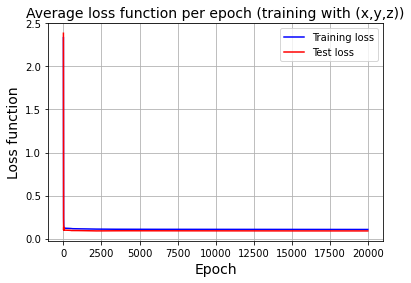

In [130]:
x = np.arange(1,nepochs+1)
# plt.plot(x[200:600],train_loss_xyz[200:600],'blue',label = 'Training loss')
# plt.plot(x[200:600],test_loss_xyz[200:600],'red',label = 'Test loss')

plt.plot(x[:epoch],train_loss_xyz[:epoch],'blue',label = 'Training loss')
plt.plot(x[:epoch],test_loss_xyz[:epoch],'red',label = 'Test loss')

#plt.ylim([-13822,-13800])

plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss function',fontsize=14)
plt.title('Average loss function per epoch (training with (x,y,z))',fontsize=14)
plt.grid()
plt.legend()
#plt.savefig('x_y_z_loss_graph_H2O',bbox_inches='tight')
plt.savefig('rot_training_x_y_z_loss_graph_H2O',bbox_inches='tight')
plt.show()

In [121]:
# x = np.arange(1,nepochs+1)
# # plt.plot(x[200:600],train_loss_xyz[200:600],'blue',label = 'Training loss')
# # plt.plot(x[200:600],test_loss_xyz[200:600],'red',label = 'Test loss')

# plt.plot(x[:1500],train_loss_xyz[:1500],'green',label = 'xyz features')
# plt.plot(x[:1500],train_loss_G_3_feat[:1500],'y',label = '3 Symmetry functions')

# #plt.ylim([-13822,-13800])

# plt.ticklabel_format(useOffset=False, style='plain')
# plt.xlabel('Epoch',fontsize=14)
# plt.ylabel('Loss function',fontsize=14)
# plt.title('Convergence: Training with (x,y,z) vs with 3 symmetry functions)',fontsize=14)
# plt.grid()
# plt.legend()
# plt.savefig('x_y_z_loss_graph_H2O_compared_with_3G',bbox_inches='tight')
# plt.show()

In [122]:
prediction_xyz = np.zeros(test_set_size)
for i in range(test_set_size):
    x1,x2,x3 = test_set_xyz[i]
    prediction_xyz[i] = net_xyz(x1, x2, x3)#[0]


tensor(-0.5770, dtype=torch.float64)


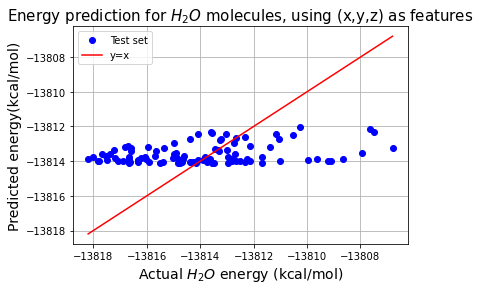

In [123]:
prediction_xyz = torch.tensor(prediction_xyz)

x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
print(min(torch.cat((test_labels,prediction_xyz),0)))
y = x
plt.plot(test_labels*var_lab+mean_lab,prediction_xyz*var_lab+mean_lab, 'o', color='blue', label = 'Test set')
plt.plot(x,y, color='red',label = 'y=x')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual $H_2O$ energy (kcal/mol)',fontsize=14)
plt.ylabel('Predicted energy(kcal/mol)',fontsize=14)
plt.title('Energy prediction for $H_2O$ molecules, using (x,y,z) as features',fontsize=15)
plt.legend()
#plt.savefig('xyz_predicted_energies_H2O',bbox_inches='tight')
plt.savefig('rot_train_xyz_predicted_energies_H2O',bbox_inches='tight')
plt.show()

In [124]:
type(prediction_xyz)

torch.Tensor

In [125]:
rotated_test_set_xyz= np.zeros((np.shape(test_set_xyz)))
for i in range(test_set_size):
    coord = test_set_xyz[N*i:N*(i+1),:]
    coord = np.transpose(coord)
    A = random_rotation_matrix()
    rotated_test_set_xyz[N*i:N*(i+1),:] = np.transpose(rotate_data(A,coord))
print(np.shape(rotated_test_set_xyz))
rotated_test_set_xyz = torch.FloatTensor(rotated_test_set_xyz)

(100, 3, 3)


In [126]:
prediction_xyz_rot = np.zeros(test_set_size)
for i in range(test_set_size):
    x1,x2,x3 = rotated_test_set_xyz[i]
    prediction_xyz_rot[i] = net_xyz(x1, x2, x3)#[0]
print(prediction_xyz*var_lab+mean_lab)

tensor([-13814.0463, -13813.9741, -13813.7030, -13814.0377, -13813.6886,
        -13813.7708, -13812.6262, -13814.0684, -13813.7690, -13813.9794,
        -13813.9872, -13814.0684, -13813.8470, -13813.4035, -13813.8464,
        -13812.3607, -13814.0387, -13813.3729, -13812.9253, -13813.8811,
        -13813.9032, -13813.6016, -13814.0991, -13814.0099, -13813.3479,
        -13813.3272, -13813.1525, -13813.8496, -13813.8539, -13813.1377,
        -13813.9152, -13814.0058, -13813.9677, -13813.1910, -13814.0254,
        -13813.9834, -13813.8865, -13813.8070, -13813.7845, -13814.0116,
        -13812.7262, -13813.7112, -13812.3149, -13813.7762, -13814.1316,
        -13812.5144, -13814.1117, -13813.9671, -13813.9383, -13812.6900,
        -13812.6956, -13813.5373, -13813.5766, -13813.8694, -13813.9441,
        -13813.3943, -13813.9472, -13813.1602, -13813.2533, -13814.0164,
        -13812.8035, -13813.4035, -13812.6944, -13813.7698, -13813.8953,
        -13813.9626, -13814.0396, -13812.0252, -138

tensor(-0.5770, dtype=torch.float64)


<ipython-input-127-3f312519f446>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_xyz = torch.tensor(prediction_xyz)


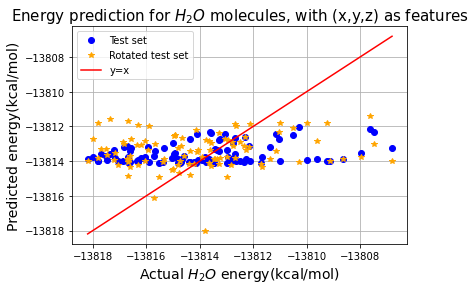

In [127]:
prediction_xyz_rot = torch.tensor(prediction_xyz_rot)
prediction_xyz = torch.tensor(prediction_xyz)

x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
print(min(torch.cat((test_labels,prediction_xyz_rot),0)))
y = x
plt.plot(test_labels*var_lab+mean_lab,prediction_xyz*var_lab+mean_lab, 'o', color='blue', label = 'Test set')
plt.plot(test_labels*var_lab+mean_lab,prediction_xyz_rot*var_lab+mean_lab, '*', color='orange', label = 'Rotated test set')
plt.plot(x,y, color='red',label = 'y=x')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual $H_2O$ energy(kcal/mol)',fontsize=14)
plt.ylabel('Predicted energy(kcal/mol)',fontsize=14)
plt.title('Energy prediction for $H_2O$ molecules, with (x,y,z) as features',fontsize=15)
plt.legend()
#plt.savefig('rot_xyz_predicted_energies_H2O',bbox_inches='tight')
plt.savefig('rot_rot_xyz_predicted_energies_H2O',bbox_inches='tight')
plt.show()

**<h1> Augmenting the dataset and training on xyz coordinates**

In [ ]:
N                        = 3           # number of atoms per molecule
number_of_features_xyz   = 3           # number of features for each atom


training_set_size    = data_size_H2O - test_set_size

    
# Computing variance and mean on the training data only!
coord_train = coordinates_water[:training_set_size,:]
var_train_xyz  = np.var(coord_train,axis=0)
mean_train_xyz = np.mean(coord_train,axis=0)


coordinates_water_norm = np.zeros((len(coordinates_water), number_of_features_xyz))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(coordinates_water)[0]):
    for j in range(1,np.shape(coordinates_water)[1]):  # omit first column since for our dataset x=0 always
        coordinates_water_norm[i,j] = (coordinates_water[i,j]-mean_train_xyz[j])/var_train_xyz[j]

data_set_xyz = np.vsplit(coordinates_water_norm,data_size_H2O)     # !!!!!!!!!!!!  change to coordinates_water_norm if you are normalising
data_set_xyz = torch.FloatTensor(data_set_xyz)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor


# labels same as before   
train_labels         = labels_norm[:training_set_size]
train_labels         = torch.FloatTensor(train_labels)
test_labels          = labels_norm[training_set_size:]
test_labels          = torch.FloatTensor(test_labels)

    
# Splitting the dataset into training and test set
training_set_xyz         = data_set_xyz[:training_set_size]
test_set_xyz             = data_set_xyz[training_set_size:]
#train and test labels same as before


#Dataset
dataset_xyz = TensorDataset(training_set_xyz, train_labels)

# Creating the batches
dataloader_xyz = torch.utils.data.DataLoader(dataset_xyz, batch_size=300, #300,
                                           shuffle=False, num_workers=2, drop_last=False) 


**<h1>Predicting Hydrogen ($H_2$) Energies**

In [ ]:
energies_H2 = np.genfromtxt('./h2/energies.txt')
print("Energies file has",np.shape(energies_H2),"entries")
#geometry_data =  read('./water/structures.xyz',index=':')
#print("Geometry file has",np.shape(geometry_data),"entries")
#print(geometry_data[0])
#geometry_data = np.array(geometry_data)


In [ ]:
# see https://education.molssi.org/python-data-analysis/01-numpy-arrays/index.html
#https://stackoverflow.com/questions/23353585/got-1-columns-instead-of-error-in-numpy

file_location = os.path.join('h2', 'structures.xyz')
xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode',invalid_raise = False)
# where invalid_raise = False was used to skip all lines in the xyz file that only have one column
symbols = xyz_file[:,0]
coordinates_H2 = (xyz_file[:,1:-1])
coordinates_H2 = coordinates_H2.astype(np.float)

#print(symbols)
#print(coordinates)

In [ ]:
atomic_numbers_H2 = (xyz_file[:,-1])

atomic_numbers_H2 = atomic_numbers_H2.astype(int)
atomic_numbers_H2 = np.reshape(atomic_numbers_H2,(len(coordinates_H2),1))
#atomic_numbers = torch.from_numpy(atomic_numbers)
print(type(atomic_numbers_H2))
#print(atomic_numbers_H2)
print(np.shape(atomic_numbers_H2))

In [ ]:
# N_H2                    = 2           # number of atoms per molecule
# number_of_features_H2   = 6           # number of features (symmetry functions) for each atom (we create one radial)
#                                    # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.

In [ ]:
# data_H2 = create_dataset(N_H2,number_of_features_H2,coordinates_H2,energies_H2, \
#                       atomic_numbers_H2,1, 200)

# training_set_H2 = data_H2[0]
# print('Training set:')
# print(type(training_set_H2))
# print(np.shape(training_set_H2))
# test_set_H2     = data_H2[1]
# print('\n')
# print('Test set:')
# print(type(test_set_H2))
# print(np.shape(test_set_H2))
# train_labels_H2 = data_H2[2]
# print('\n')
# print('Training labels:')
# print(type(train_labels_H2))
# print(np.shape(train_labels_H2))
# test_labels_H2  = data_H2[3]
# print('\n')
# print('Test labels:')
# print(type(test_labels_H2))
# print(np.shape(test_labels_H2))
# dataloader_H2   = data_H2[4]
# print('\n')
# print('data_H2loader:')
# print(type(dataloader_H2))
# print(np.shape(dataloader_H2))

# var_lab_H2 = data_H2[5]
# print('\n')
# print('Variance of labels:')
# print(type(var_lab_H2))
# print(var_lab_H2)

# mean_lab_H2 = data_H2[6]
# print('\n')
# print('Mean value of labels:')
# print(type(mean_lab_H2))
# print(mean_lab_H2)

# test_set_rot_H2 = data_H2[7]
# print('\n')
# print('Rotated test set:')
# print(type(test_set_rot_H2))
# print(np.shape(test_set_rot_H2))

# labels_norm_H2 = data_H2[8]
# print('\n')
# print('Normalised labels:')
# print(type(labels_norm_H2))
# print(np.shape(labels_norm_H2))

**Creating features using only radial symmetry functions**

In [ ]:
N_H2                    = 2           # number of atoms per molecule
number_of_features_H2   = 6           # number of features (symmetry functions) for each atom
                                       
    
# heta   = np.linspace(0.01, 4, num=number_of_features_H2)
# random.shuffle(heta)

# Rs     = np.linspace(0, 1, num=number_of_features_H2)
# random.shuffle(Rs)

# lambdaa = np.ones(number_of_features_H2)
# random.shuffle(lambdaa)

# zeta    = np.linspace(0, 8, num=number_of_features_H2)
# random.shuffle(zeta)


heta    = [0.3,  4.,    3.202, 1.606, 2.404, 0.808] 
zeta    = [8.,  0, 3.2, 4.8 , 6.4, 8 ]
Rs      = [0.8, 0.4, 2, 1. ,  0.,  0.6]
lambdaa = [1., 1., 1., 1. , 1., 1.]


data_size_H2            = np.shape(energies_H2)[0]        # We have 500 H2 molecule conformations
training_set_size_H2    = data_size_H2 - 50

    
G_H2 = np.zeros((len(coordinates_H2), number_of_features_H2))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)

for i in range(data_size_H2):
    coord = coordinates_H2[N_H2*i:N_H2*(i+1),:]
    Dp    = pairwise_distances(coord)
    for j in range(0,number_of_features_H2):
        G_H2[N_H2*i:N_H2*(i+1),j]   = radial_BP_symm_func(Dp,N_H2,heta[j],Rs[j])     
    
# Computing variance and mean on the training data only!
G_train_H2 = G_H2[:training_set_size_H2,:]
var_train_H2  = np.var(G_train_H2,axis=0)
mean_train_H2 = np.mean(G_train_H2,axis=0)

G_norm_H2 = np.zeros((len(coordinates_H2), number_of_features_H2))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G_H2)[0]):
    for j in range(np.shape(G_H2)[1]):
        G_norm_H2[i,j] = (G_H2[i,j]-mean_train_H2[j])/var_train_H2[j]   

G_norm_H2 = np.append(G_norm_H2, atomic_numbers_H2, axis=1)
        
        
data_set_H2 = np.vsplit(G_norm_H2,data_size_H2)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set_H2 = torch.FloatTensor(data_set_H2)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

# print(data_set[0])
# print(data_set[0][1][1])

labels_H2 = energies_H2          # turning energies into a (1000) tensor


# Computing variance and mean on the training data only!
lab_train_H2 = labels_H2[:training_set_size_H2]
var_lab_H2  = np.var(lab_train_H2,axis=0)
mean_lab_H2 = np.mean(lab_train_H2,axis=0)
print(mean_lab_H2)

labels_norm_H2 = np.zeros((np.shape(labels_H2)))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(labels_H2)[0]):
    labels_norm_H2[i] = (labels_H2[i]-mean_lab_H2)/var_lab_H2  
    
    
labels_norm_H2 = torch.FloatTensor(labels_norm_H2)      
    
    
# # Splitting the dataset into training and test set
# training_set_H2         = data_set_H2[:training_set_size_H2]
# test_set_H2             = data_set_H2[training_set_size_H2:]

# train_labels_H2         = labels_norm_H2[:training_set_size_H2]
# test_labels_H2          = labels_norm_H2[training_set_size_H2:]

# # Dataset
# dataset_H2 = TensorDataset(training_set_H2, train_labels_H2)
# #print(dataset[0])

# # Creating the batches
# dataloader_H2 = torch.utils.data.DataLoader(dataset_H2, batch_size=400,
#                                            shuffle=True, num_workers=2, drop_last=False) # ?????

# print(np.shape(training_set_H2))

In [ ]:
# print(G_norm[:100,:-1])

In [ ]:
class Subnets_h2(nn.Module):
    def __init__(self):
        super(Subnets_h2, self).__init__()
        self.fc1 = nn.Linear(7,3)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(3,3)        
        self.fc3 = nn.Linear(3, 1)


    def forward(self, x):
        x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN_h2(nn.Module):
    def __init__(self):
        super(BPNN_h2, self).__init__()
        self.network1 = Subnets_h2()
        self.network2 = Subnets_h2()
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        
#         print(x1)
#         print(x2)
        
        x = torch.cat((x1, x2), 0) 
        x = torch.sum(x)                   #??????????????????????????? try average pooling?
        x = torch.reshape(x,[1])
        return x



model_h2 = BPNN_h2()
    
    
    
print('Copying weights!')
#'Network1','layer 1'
# 'weights'
model_h2.network1.fc1.weight = net.network1.fc1.weight 
# print('biases')
model_h2.network1.fc1.bias = net.network1.fc1.bias

# print('layer 2')
# print('weights')
model_h2.network1.fc2.weight = net.network1.fc2.weight 
# print('biases')
model_h2.network1.fc2.bias = net.network1.fc2.bias

# print('layer 3')
# print('weights')
model_h2.network1.fc3.weight = net.network1.fc3.weight 
# print('biases')
model_h2.network1.fc3.bias = net.network1.fc3.bias



#'Network2','layer 1'
# 'weights'
model_h2.network2.fc1.weight = net.network2.fc1.weight 
# print('biases')
model_h2.network2.fc1.bias = net.network2.fc1.bias


# print('layer 2')
# print('weights')
model_h2.network2.fc2.weight = net.network2.fc2.weight 
# print('biases')
model_h2.network2.fc2.bias = net.network2.fc2.bias

# print('layer 3')
# print('weights')
model_h2.network2.fc3.weight = net.network2.fc3.weight 
# print('biases')
model_h2.network2.fc3.bias = net.network2.fc3.bias


print('Finished copying weights!')


In [ ]:
x1, x2 = data_set_H2[0]
print('x1',x1)
print('x2',x2)

output = model_h2(x1, x2)
print('output')
print(output)
print(output*var_lab_H2+mean_lab_H2)
print(np.shape(output))

In [ ]:
prediction_H2 = torch.zeros(data_size_H2)
for i in range(data_size_H2):
    x1, x2 = data_set_H2[i]
#     print('x1',x1)
#     print('x2',x2)
    with torch.no_grad():
        prediction_H2[i] = model_h2(x1, x2)
    print(prediction_H2[i]*var_lab_H2+mean_lab_H2)


In [ ]:
# print(prediction_H2*var_lab_H2+mean_lab_H2)

In [ ]:
print(np.shape(labels_norm_H2))
labels_norm_H2 = np.array(labels_norm_H2)
print(np.mean(labels_norm_H2*var_lab_H2+mean_lab_H2,axis=0))

In [ ]:
prediction_H2 = torch.tensor(prediction_H2)

x = np.linspace(min(labels_H2), max(labels_H2))
#print(min(torch.cat((test_labels_H2,prediction_H2),0)))
y = x
plt.plot(labels_H2,prediction_H2*var_lab_H2+mean_lab_H2, 'o', color='blue', label = 'test set')
plt.plot(x,y, color='red',label = 'y=x')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction_H2),0)), max(torch.cat((test_labels,prediction_H2),0))])
#plt.ylim([min(torch.cat((test_labels,prediction_H2),0)), max(torch.cat((test_labels,prediction_H2)))])
#plt.ylim([-500,-700])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual $H_2$ energy value (kcal/mol)',fontsize=14)
plt.ylabel('Predicted $H_2$ energy value (kcal/mol)',fontsize=14)
plt.title('Actual vs Predicted energy value for $H_2$ molecules',fontsize=15)
plt.legend()
plt.savefig('predicted_energies_H2_using_H2O_trained_net',bbox_inches='tight')
plt.show()


In [ ]:
print('layer 1')
print('weights')
print(net.network1.fc1.weight)
print('biases')
print(net.network1.fc1.bias)

**<h1>Drawing a neural network using matplotlib**

In [ ]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    for sn in range(3):   
        n_layers = len(layer_sizes)
        v_spacing = (top - bottom)/float(max(layer_sizes))+0.015  #!!!!!!!!
        h_spacing = (right - left)/float(len(layer_sizes) - 1)
        # Nodes
        for n, layer_size in enumerate(layer_sizes):
            layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2. + 0.325*sn  #!!!!!!!!!!!!!
            for m in range(layer_size):
                x = n*h_spacing + left
                y = layer_top - m*v_spacing
                circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), 0.024, #v_spacing/4., #!!!!!!!
                                color='w', ec='k', zorder=2.7)
                ax.add_artist(circle)
                if n == 0:
                    lab   = "$G_{0}^{1}$".format(4-(sn+1),m+1)
                    label = ax.annotate(lab, xy=(x, y-0.01), fontsize=20, ha="center")
                if n == 1:
                    lab   = '$y^1_{0}$'.format(m+1)
                    label = ax.annotate(lab, xy=(x, y-0.01), fontsize=20, ha="center")
                if n == 2:
                    lab   = '$y^2_{0}$'.format(m+1)
                    label = ax.annotate(lab, xy=(x, y-0.01), fontsize=20, ha="center")
                if n == 3:
                    lab   = '$E_{0}$'.format((4-(sn+1)))
                    label = ax.annotate(lab, xy=(x, y-0.01), fontsize=20, ha="center")
            
            
            # Edges
            for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
                layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.+ 0.325*sn
                layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.+ 0.325*sn
                for m in range(layer_size_a):
                    for o in range(layer_size_b):
                        line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                          [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                        ax.add_artist(line)
    
    
  
        circle = plt.Circle((0.9,0.526),0.032,color='w', ec='k', zorder=2.7)
        ax.add_artist(circle)
        label = ax.annotate('$E_{tot}$', xy=(0.9,0.526-0.01), fontsize=20, ha="center")
        
        line = plt.Line2D([0.68,0.89],[0.525,0.525], c='k')
        ax.add_artist(line)

        line = plt.Line2D([0.727,0.89],[0.21,0.545], c='k')
        ax.add_artist(line)
        
        line = plt.Line2D([0.72,0.886],[0.85,0.51], c='k')
        ax.add_artist(line)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .7, .1, .3, [6,3, 3, 1])
fig.savefig('subnet.png')

In [ ]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            x = n*h_spacing + left
            y = layer_top - m*v_spacing
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                            color='w', ec='k', zorder=2.7)
            ax.add_artist(circle)
            if n == 0:
                lab   = "$G_i^{0}$".format(m+1)
                label = ax.annotate(lab, xy=(x, y-0.01), fontsize=20, ha="center")
            if n == 1:
                lab   = '$y^1_{0}$'.format(m+1)
                label = ax.annotate(lab, xy=(x, y-0.01), fontsize=20, ha="center")
            if n == 2:
                lab   = '$y^2_{0}$'.format(m+1)
                label = ax.annotate(lab, xy=(x, y-0.01), fontsize=20, ha="center")
            if n == 3:
                lab   = '$E_i$'
                label = ax.annotate(lab, xy=(x, y-0.01), fontsize=20, ha="center")
            
            
        # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                    [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
    
    
    
    


In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [6,3, 3, 1])
fig.savefig('subnet.png')